In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# fix the random seed; don't modify this
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(23459078)
if torch.cuda.is_available():
    torch.cuda.manual_seed(23459078)

In [2]:
input_data = np.load('vae_board_grade.npy', allow_pickle=True)
x, y = input_data[:, 1], input_data[:, 0]

all_boards = np.stack(x).reshape(-1, 18, 11)
all_classes = np.stack(y).reshape(-1, 2)

# Convert data to PyTorch tensors
x_tensor = torch.tensor(all_boards, dtype=torch.float32)
y_tensor = torch.tensor(all_classes, dtype=torch.float32)
# create the dataset (no splitting here since valid sets have no meaning in GANS)
train_dataset = data.TensorDataset(x_tensor, y_tensor)

# now find all of the indices where there are no holds
# this will be useful later when we smooth the examples
zero_indices = (x_tensor == 0).all(dim=0).nonzero()
print(zero_indices)

tensor([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  7],
        [ 1,  8],
        [ 1, 10],
        [ 2,  0],
        [ 2,  2],
        [ 2,  4],
        [ 2,  5],
        [ 2,  6],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 10],
        [ 3,  0],
        [ 3,  2],
        [ 3,  3],
        [ 3,  4],
        [ 3,  5],
        [ 3,  7],
        [ 3,  9],
        [ 3, 10],
        [ 4,  1],
        [ 4,  4],
        [ 4,  6],
        [ 5,  7],
        [ 6,  0],
        [ 7,  0],
        [13,  1],
        [14,  9],
        [14, 10],
        [16,  0],
        [16,  1],
        [16,  2],
        [16,  4],
        [16,  5],
        [16,  7],
        [16,  8],
        [16,  9],
        [16, 10],
        [1

Examples


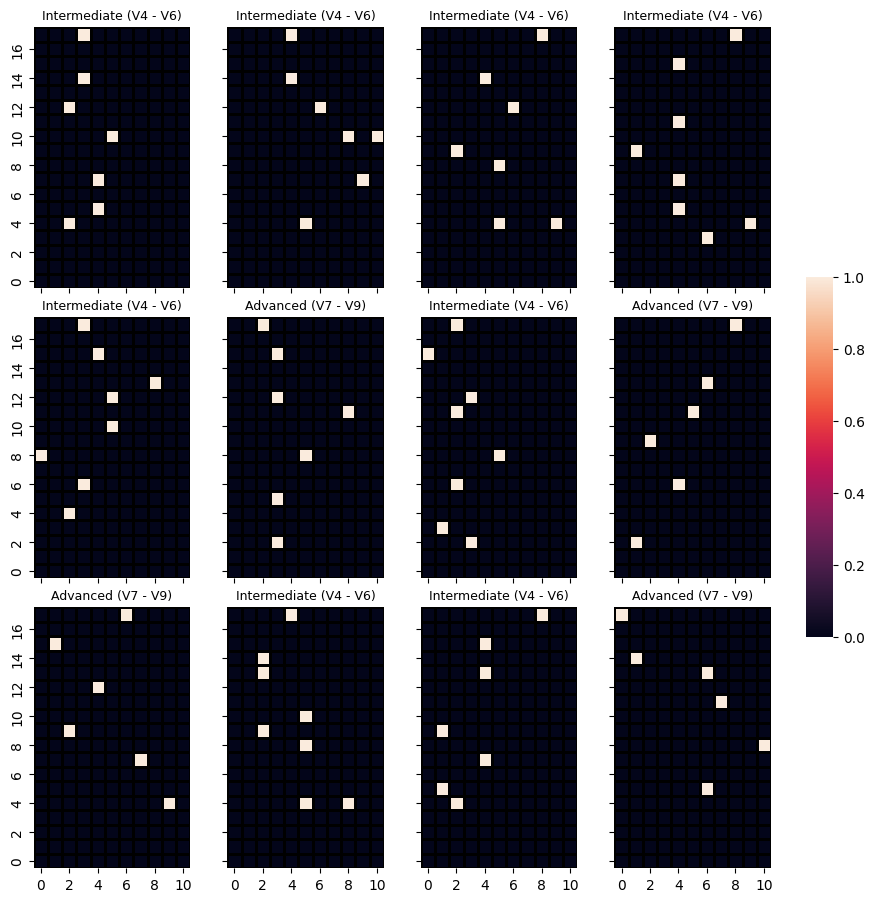

Noised examples


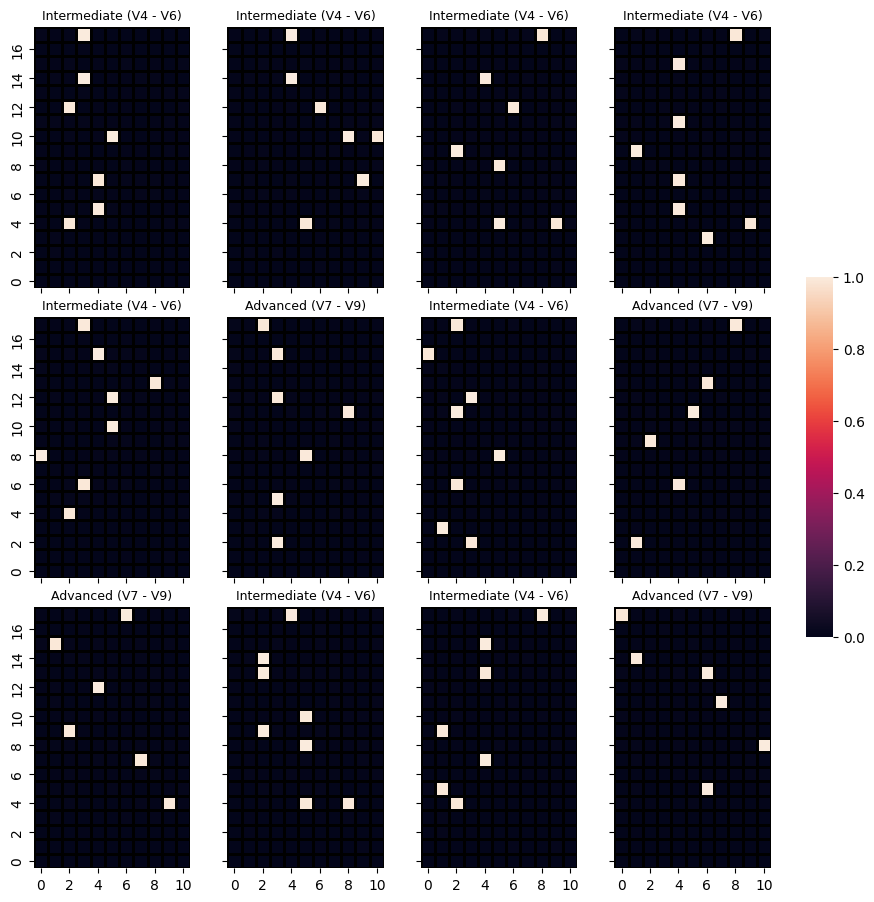

torch.Size([12, 18, 11])

In [49]:
# define a way to generate an image grid to view how our GAN is training
import matplotlib.pyplot as plt
import seaborn as sns

class_to_title = {
    0: "Intermediate (V4 - V6)",
    1: "Advanced (V7 - V9)",
    2: "Expert (V10+)"
}

# for plotting a single example
def plot_example(tensor, tensor_class, figure_size = (9, 9)):
    plt.figure(figsize=figure_size)
    x = sns.heatmap(tensor.cpu(), linewidths=1, linecolor='black')
    plt.title(class_to_title[int(torch.sum(tensor_class.cpu()).item())])
    x.invert_yaxis()
    plt.show()

# we plot 12 examples, 4 from each class
def plot_examples(tensor_batch, tensor_classes, figure_size = (9, 9)):
    fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize = figure_size)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    for i, ax in enumerate(axes.flat):
        x = sns.heatmap(tensor_batch[i].cpu(), linewidths=1, linecolor='black', ax=ax, cbar=(i == 0), vmin=0, vmax=1, cbar_ax=None if i else cbar_ax)
        ax.set_title(class_to_title[int(torch.sum(tensor_classes[i].cpu()).item())], fontsize = figure_size[0])
        x.invert_yaxis()
    plt.show()

# first plot our unsmoothed examples
print("Examples")
plot_examples(x_tensor[:12], y_tensor[:12])

# then check how adding noise changes the examples
eps = 2e-2
probs = torch.zeros_like(x_tensor[:12]).uniform_(0, eps)
smoothed_x = x_tensor[:12] * (1 - probs) + probs / 2

# now set the items we know don't ever have holds to zero (hold showing up in these spots are of probability zero)
smoothed_x[:, zero_indices[:, 0], zero_indices[:, 1]] = 0

# plot our noisy examples
print("Noised examples")
plot_examples(smoothed_x, y_tensor[:12])
smoothed_x.size()

In [4]:
# create an oversampler
# since we dont have balance, we are going to make a balanced weight sampler, to make sure discriminator gets no advantage
# if we use our imbalanced weights from before, the discriminator may be able to label all of one class as fake and ruin learning
def calculate_class_weights(data, num_classes):
    return [1/num_classes for x in range(num_classes)]

# Calculate sample weights from class weights
class_weights = calculate_class_weights(train_dataset, 3)
labels = [max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])]) for sample in train_dataset]
sample_weights = [class_weights[label] for label in labels]

# Create WeightedRandomSampler using sample weights
sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

print("Class weights:", class_weights)

Class weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [23]:
INPUT_DIM = 18 * 11
HIDDEN_DIM_OUTER = 64
HIDDEN_DIM_INNER = 32
LATENT_DIM_G = 8
CLASS_DIM = 2

class Generator(nn.Module):
    def __init__(self, output_dim, latent_dim, class_dim):
        super().__init__()

        self.latent_fc = nn.Linear(latent_dim + class_dim, HIDDEN_DIM_INNER)
        self.hidden_fc = nn.Linear(HIDDEN_DIM_INNER, HIDDEN_DIM_INNER)
        self.hidden_fc2 = nn.Linear(HIDDEN_DIM_INNER, HIDDEN_DIM_OUTER)
        self.output_fc = nn.Linear(HIDDEN_DIM_OUTER, output_dim)

        self.mish = nn.Mish()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h_1 = self.mish(self.latent_fc(x))
        h_2 = self.mish(self.hidden_fc(h_1))
        h_3 = self.mish(self.hidden_fc2(h_2))
        x_new = self.sigmoid(self.output_fc(h_3))
        return x_new

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim, class_dim):
        super().__init__()

        self.input_conv2d = nn.Conv2d(1, 4, 11, padding=5)
        self.pool = nn.AdaptiveMaxPool2d(9)
        self.flatten = nn.Flatten()
        self.hidden_fc = nn.Linear(4 * INPUT_DIM + class_dim, HIDDEN_DIM_OUTER)
        self.hidden_fc2 = nn.Linear(HIDDEN_DIM_OUTER, HIDDEN_DIM_INNER)
        self.output_fc = nn.Linear(HIDDEN_DIM_INNER, output_dim)

        self.mish = nn.Mish()

    def forward(self, x):
        x, c = torch.split(x, [INPUT_DIM, CLASS_DIM], dim=1) # to use our convolution we split our class off of the input
        x = x.view(-1, 18, 11, 1).permute(0, 3, 1, 2) # convert to B, C, H, W for convolution
        c_1 = F.mish(self.input_conv2d(x))
        h_pool = self.flatten(c_1)
        h_1 = torch.cat([h_pool, c], 1) # add the class to the flat vector
        h_2 = self.mish(self.hidden_fc(h_1))
        h_3 = self.mish(self.hidden_fc2(h_2))
        y_pred = self.output_fc(h_3)
        return y_pred

In [24]:
import random

tensor_dict = {
    0: torch.tensor([0, 0]),
    1: torch.tensor([1, 0]),
    2: torch.tensor([1, 1]),
}

def generate_class_labels(n_labels):
    selected_tensors = []
    for _ in range(n_labels):
        tensor_idx = random.choice(list(tensor_dict.keys()))
        selected_tensors.append(tensor_dict[tensor_idx])
    result_tensor = torch.stack(selected_tensors)
    return result_tensor

# Print the resulting 2D tensor
print("Resulting 2D tensor:")
print(generate_class_labels(8))

Resulting 2D tensor:
tensor([[0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 0]])


In [25]:
def gradient_penalty(generator, discriminator, real_data, generated_data, device, gp_weight = 10, eps = 1e-12):
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(real_data.size()).to(device)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True).to(device)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated, 
                                    grad_outputs=torch.ones(prob_interpolated.size()).to(device), 
                                    create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + eps)

    if gradients_norm.isnan().any():
        print(gradients_norm)

    # Return gradient penalty
    return gp_weight * ((gradients_norm - 1) ** 2).mean()

Generator - Number of trainable parameters: 16,390
Discriminator - Number of trainable parameters: 53,481
Checkpoint 0 - generated board probability maps (with same latent generation): 


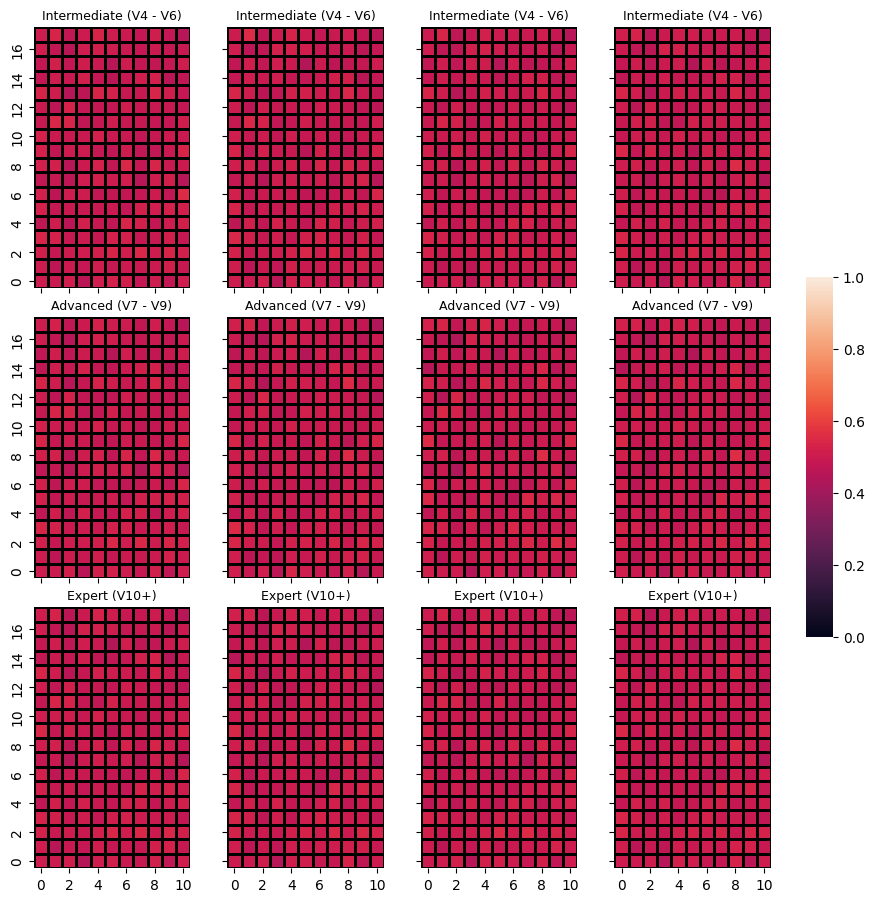

Epoch: 01 | Epoch Time: 0m 6s | Generator Loss: 0.050 | Discriminator Loss: 0.152


Epoch: 02 | Epoch Time: 0m 5s | Generator Loss: 0.028 | Discriminator Loss: -0.010


Epoch: 03 | Epoch Time: 0m 5s | Generator Loss: 0.024 | Discriminator Loss: -0.011


Epoch: 04 | Epoch Time: 0m 5s | Generator Loss: 0.023 | Discriminator Loss: -0.006


Epoch: 05 | Epoch Time: 0m 5s | Generator Loss: 0.023 | Discriminator Loss: -0.003


Epoch: 06 | Epoch Time: 0m 5s | Generator Loss: 0.031 | Discriminator Loss: -0.009


Epoch: 07 | Epoch Time: 0m 4s | Generator Loss: 0.030 | Discriminator Loss: -0.009


Epoch: 08 | Epoch Time: 0m 5s | Generator Loss: 0.034 | Discriminator Loss: -0.010


Epoch: 09 | Epoch Time: 0m 5s | Generator Loss: 0.040 | Discriminator Loss: -0.011


Epoch: 10 | Epoch Time: 0m 5s | Generator Loss: 0.056 | Discriminator Loss: -0.016
Checkpoint 1 - generated board probability maps (with same latent generation): 


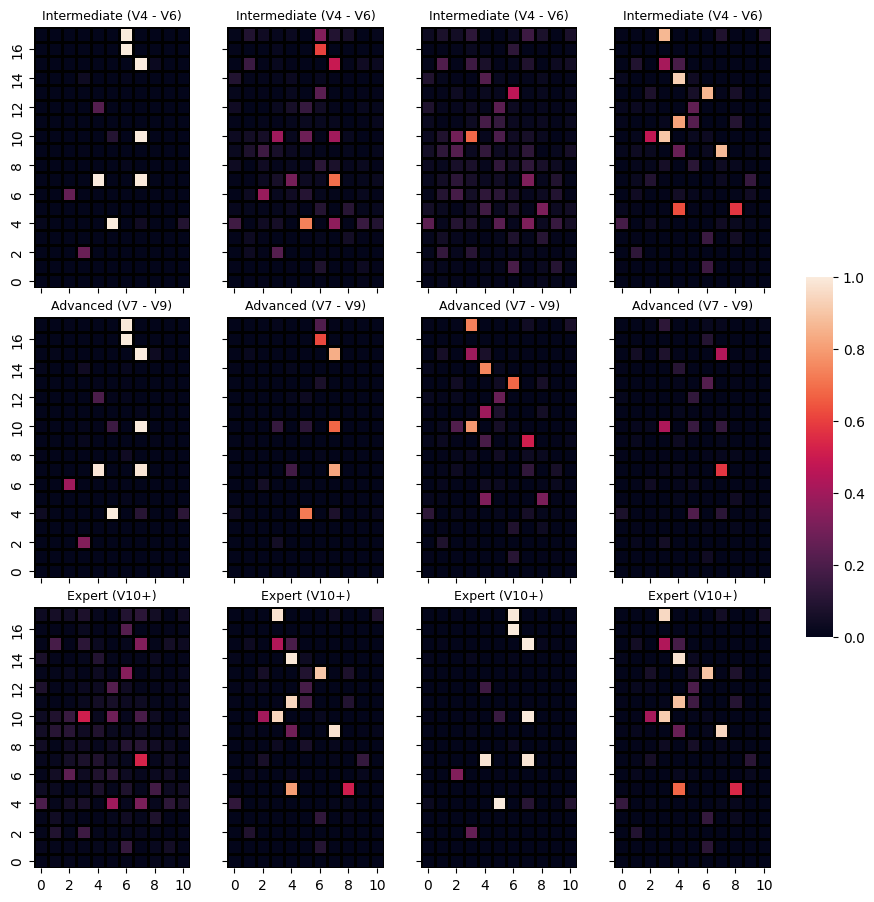

Epoch: 11 | Epoch Time: 0m 6s | Generator Loss: 0.068 | Discriminator Loss: -0.021


Epoch: 12 | Epoch Time: 0m 5s | Generator Loss: 0.079 | Discriminator Loss: -0.024


Epoch: 13 | Epoch Time: 0m 4s | Generator Loss: 0.077 | Discriminator Loss: -0.023


Epoch: 14 | Epoch Time: 0m 4s | Generator Loss: 0.082 | Discriminator Loss: -0.023


Epoch: 15 | Epoch Time: 0m 5s | Generator Loss: 0.089 | Discriminator Loss: -0.024


Epoch: 16 | Epoch Time: 0m 5s | Generator Loss: 0.085 | Discriminator Loss: -0.023


Epoch: 17 | Epoch Time: 0m 4s | Generator Loss: 0.079 | Discriminator Loss: -0.022


Epoch: 18 | Epoch Time: 0m 5s | Generator Loss: 0.074 | Discriminator Loss: -0.022


Epoch: 19 | Epoch Time: 0m 5s | Generator Loss: 0.069 | Discriminator Loss: -0.021


Epoch: 20 | Epoch Time: 0m 4s | Generator Loss: 0.064 | Discriminator Loss: -0.020
Checkpoint 2 - generated board probability maps (with same latent generation): 


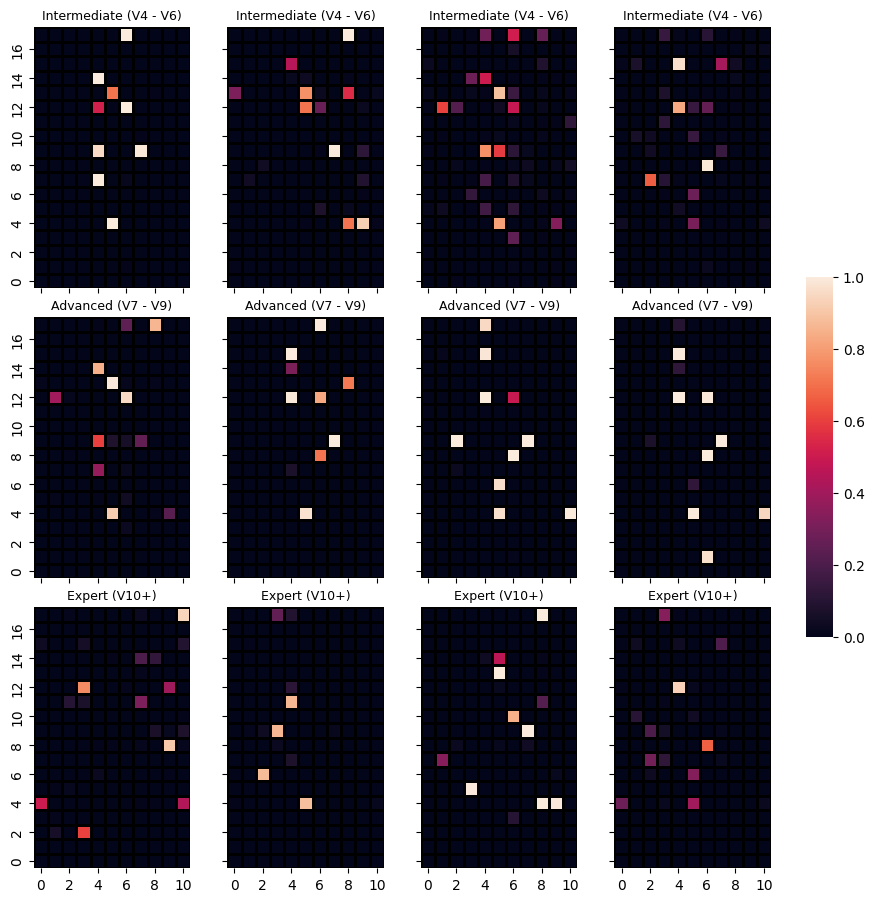

Epoch: 21 | Epoch Time: 0m 6s | Generator Loss: 0.063 | Discriminator Loss: -0.020


Epoch: 22 | Epoch Time: 0m 5s | Generator Loss: 0.064 | Discriminator Loss: -0.020


Epoch: 23 | Epoch Time: 0m 4s | Generator Loss: 0.059 | Discriminator Loss: -0.020


Epoch: 24 | Epoch Time: 0m 5s | Generator Loss: 0.054 | Discriminator Loss: -0.020


Epoch: 25 | Epoch Time: 0m 5s | Generator Loss: 0.054 | Discriminator Loss: -0.020


Epoch: 26 | Epoch Time: 0m 4s | Generator Loss: 0.052 | Discriminator Loss: -0.020


Epoch: 27 | Epoch Time: 0m 5s | Generator Loss: 0.056 | Discriminator Loss: -0.020


Epoch: 28 | Epoch Time: 0m 5s | Generator Loss: 0.058 | Discriminator Loss: -0.020


Epoch: 29 | Epoch Time: 0m 5s | Generator Loss: 0.062 | Discriminator Loss: -0.018


Epoch: 30 | Epoch Time: 0m 5s | Generator Loss: 0.062 | Discriminator Loss: -0.020
Checkpoint 3 - generated board probability maps (with same latent generation): 


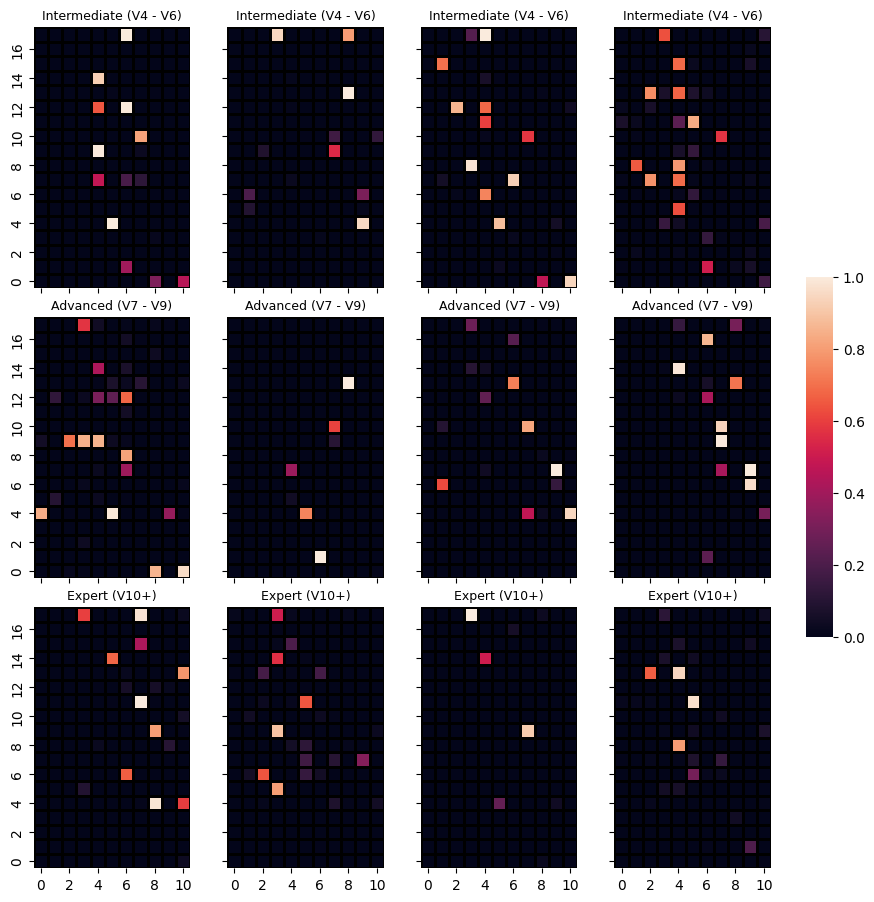

Epoch: 31 | Epoch Time: 0m 6s | Generator Loss: 0.064 | Discriminator Loss: -0.020


Epoch: 32 | Epoch Time: 0m 5s | Generator Loss: 0.064 | Discriminator Loss: -0.019


Epoch: 33 | Epoch Time: 0m 4s | Generator Loss: 0.063 | Discriminator Loss: -0.019


Epoch: 34 | Epoch Time: 0m 5s | Generator Loss: 0.065 | Discriminator Loss: -0.018


Epoch: 35 | Epoch Time: 0m 5s | Generator Loss: 0.064 | Discriminator Loss: -0.017


Epoch: 36 | Epoch Time: 0m 4s | Generator Loss: 0.067 | Discriminator Loss: -0.018


Epoch: 37 | Epoch Time: 0m 5s | Generator Loss: 0.070 | Discriminator Loss: -0.018


Epoch: 38 | Epoch Time: 0m 5s | Generator Loss: 0.066 | Discriminator Loss: -0.017


Epoch: 39 | Epoch Time: 0m 4s | Generator Loss: 0.067 | Discriminator Loss: -0.018


Epoch: 40 | Epoch Time: 0m 5s | Generator Loss: 0.062 | Discriminator Loss: -0.018
Checkpoint 4 - generated board probability maps (with same latent generation): 


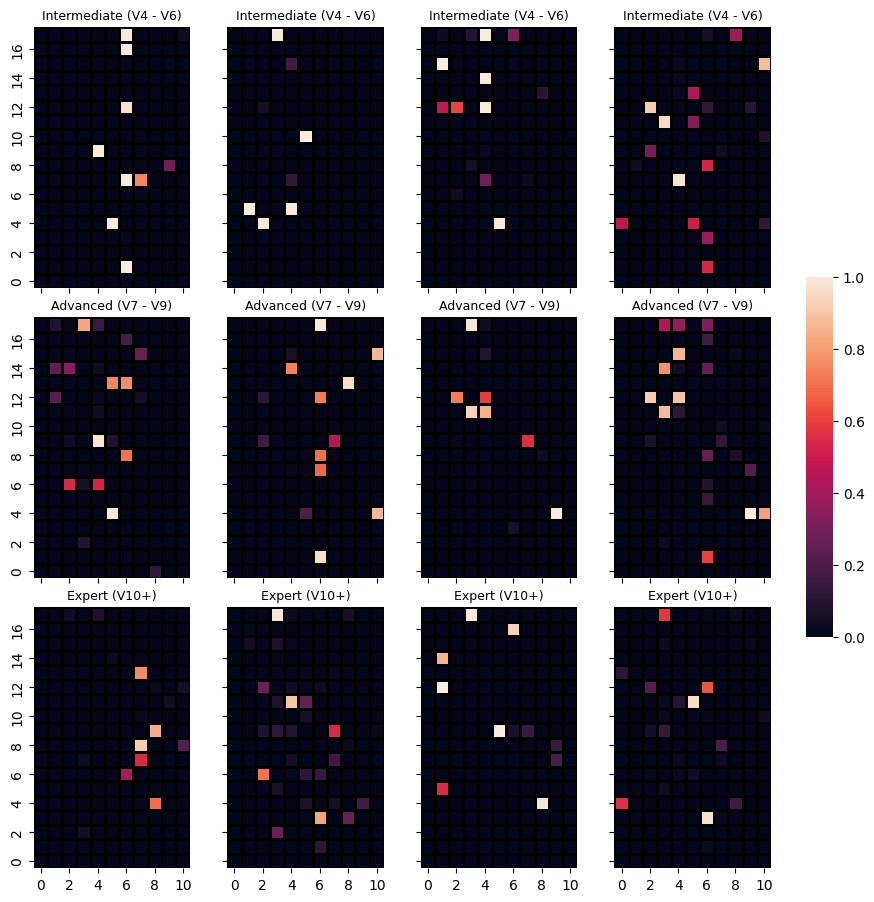

Epoch: 41 | Epoch Time: 0m 6s | Generator Loss: 0.066 | Discriminator Loss: -0.014


Epoch: 42 | Epoch Time: 0m 5s | Generator Loss: 0.068 | Discriminator Loss: -0.016


Epoch: 43 | Epoch Time: 0m 5s | Generator Loss: 0.070 | Discriminator Loss: -0.017


Epoch: 44 | Epoch Time: 0m 5s | Generator Loss: 0.069 | Discriminator Loss: -0.016


Epoch: 45 | Epoch Time: 0m 4s | Generator Loss: 0.062 | Discriminator Loss: -0.016


Epoch: 46 | Epoch Time: 0m 5s | Generator Loss: 0.058 | Discriminator Loss: -0.015


Epoch: 47 | Epoch Time: 0m 5s | Generator Loss: 0.061 | Discriminator Loss: -0.015


Epoch: 48 | Epoch Time: 0m 5s | Generator Loss: 0.061 | Discriminator Loss: -0.015


Epoch: 49 | Epoch Time: 0m 5s | Generator Loss: 0.064 | Discriminator Loss: -0.016


Epoch: 50 | Epoch Time: 0m 5s | Generator Loss: 0.066 | Discriminator Loss: -0.016
Checkpoint 5 - generated board probability maps (with same latent generation): 


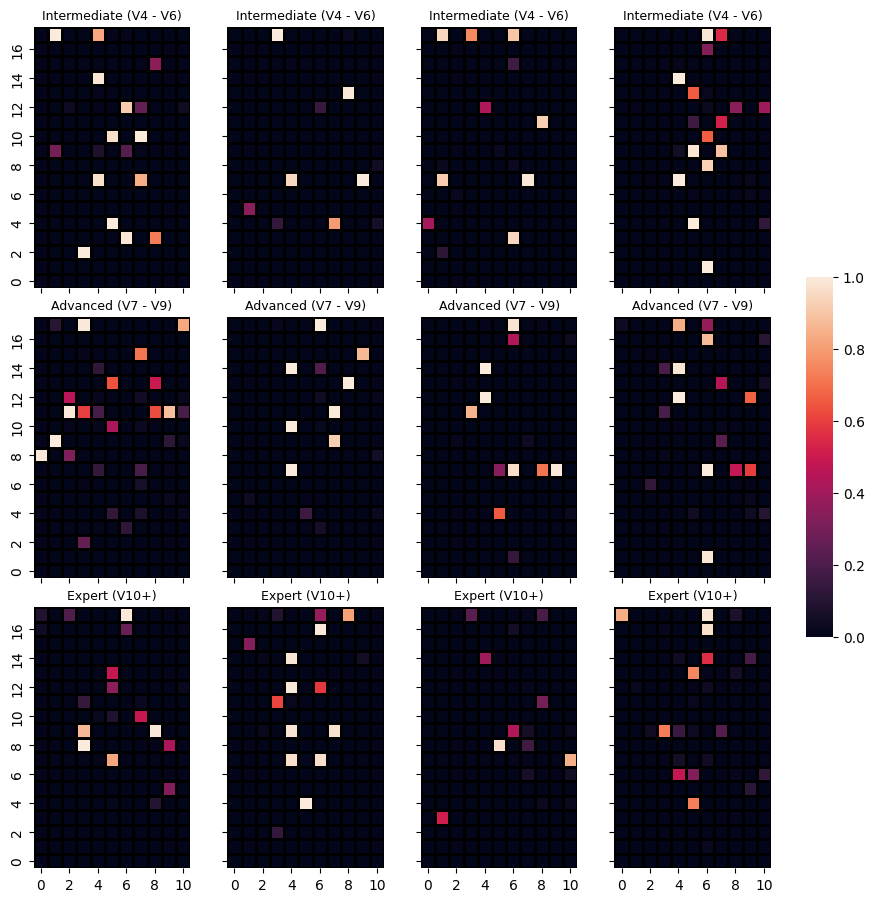

Epoch: 51 | Epoch Time: 0m 6s | Generator Loss: 0.069 | Discriminator Loss: -0.016


Epoch: 52 | Epoch Time: 0m 5s | Generator Loss: 0.072 | Discriminator Loss: -0.015


Epoch: 53 | Epoch Time: 0m 5s | Generator Loss: 0.065 | Discriminator Loss: -0.017


Epoch: 54 | Epoch Time: 0m 4s | Generator Loss: 0.055 | Discriminator Loss: -0.017


Epoch: 55 | Epoch Time: 0m 5s | Generator Loss: 0.054 | Discriminator Loss: -0.015


Epoch: 56 | Epoch Time: 0m 5s | Generator Loss: 0.058 | Discriminator Loss: -0.016


Epoch: 57 | Epoch Time: 0m 5s | Generator Loss: 0.058 | Discriminator Loss: -0.016


Epoch: 58 | Epoch Time: 0m 5s | Generator Loss: 0.059 | Discriminator Loss: -0.016


Epoch: 59 | Epoch Time: 0m 5s | Generator Loss: 0.056 | Discriminator Loss: -0.015


Epoch: 60 | Epoch Time: 0m 4s | Generator Loss: 0.061 | Discriminator Loss: -0.016
Checkpoint 6 - generated board probability maps (with same latent generation): 


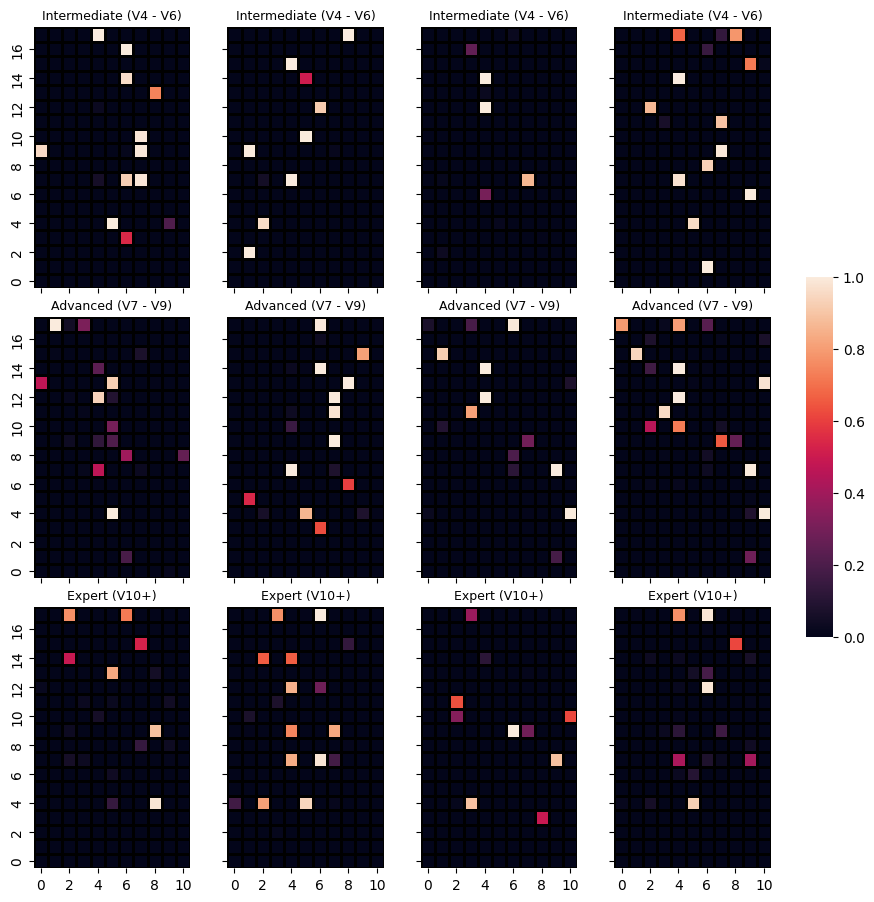

Epoch: 61 | Epoch Time: 0m 6s | Generator Loss: 0.065 | Discriminator Loss: -0.017


Epoch: 62 | Epoch Time: 0m 5s | Generator Loss: 0.067 | Discriminator Loss: -0.017


Epoch: 63 | Epoch Time: 0m 5s | Generator Loss: 0.068 | Discriminator Loss: -0.018


Epoch: 64 | Epoch Time: 0m 4s | Generator Loss: 0.070 | Discriminator Loss: -0.016


Epoch: 65 | Epoch Time: 0m 5s | Generator Loss: 0.067 | Discriminator Loss: -0.017


Epoch: 66 | Epoch Time: 0m 5s | Generator Loss: 0.066 | Discriminator Loss: -0.016


Epoch: 67 | Epoch Time: 0m 4s | Generator Loss: 0.072 | Discriminator Loss: -0.017


Epoch: 68 | Epoch Time: 0m 5s | Generator Loss: 0.073 | Discriminator Loss: -0.017


Epoch: 69 | Epoch Time: 0m 5s | Generator Loss: 0.072 | Discriminator Loss: -0.017


Epoch: 70 | Epoch Time: 0m 5s | Generator Loss: 0.071 | Discriminator Loss: -0.018
Checkpoint 7 - generated board probability maps (with same latent generation): 


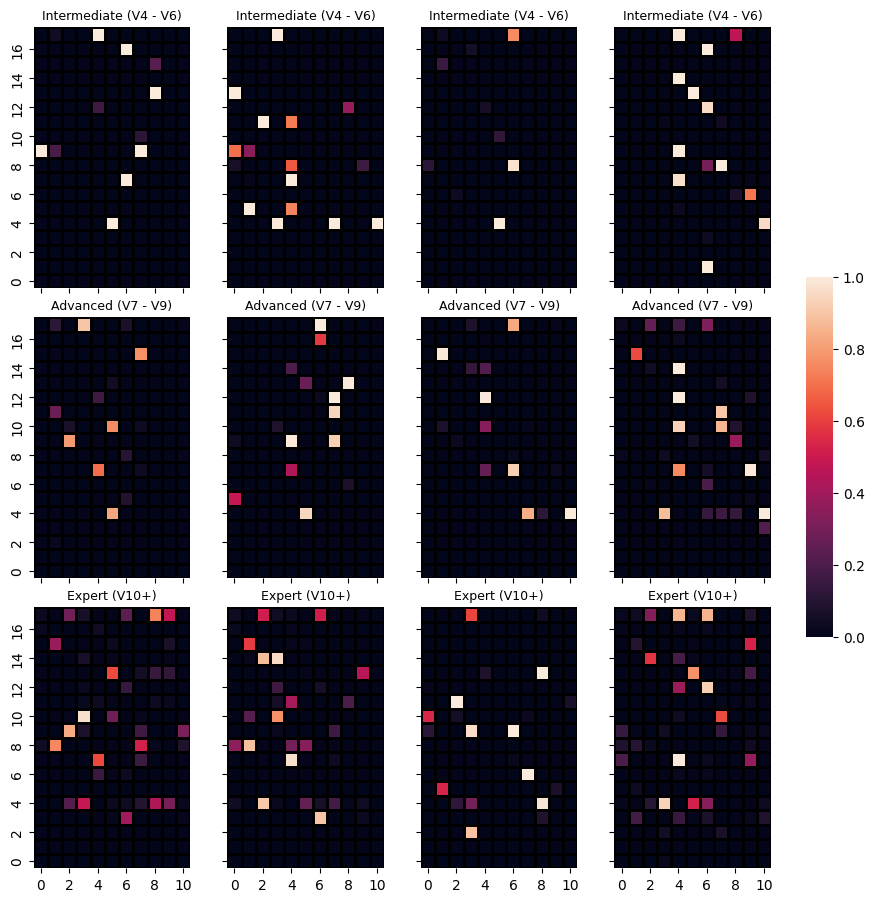

Epoch: 71 | Epoch Time: 0m 6s | Generator Loss: 0.067 | Discriminator Loss: -0.018


Epoch: 72 | Epoch Time: 0m 5s | Generator Loss: 0.069 | Discriminator Loss: -0.017


Epoch: 73 | Epoch Time: 0m 4s | Generator Loss: 0.071 | Discriminator Loss: -0.012


Epoch: 74 | Epoch Time: 0m 5s | Generator Loss: 0.069 | Discriminator Loss: -0.018


Epoch: 75 | Epoch Time: 0m 5s | Generator Loss: 0.066 | Discriminator Loss: -0.016


Epoch: 76 | Epoch Time: 0m 4s | Generator Loss: 0.064 | Discriminator Loss: -0.018


Epoch: 77 | Epoch Time: 0m 5s | Generator Loss: 0.067 | Discriminator Loss: -0.020


Epoch: 78 | Epoch Time: 0m 5s | Generator Loss: 0.067 | Discriminator Loss: -0.016


Epoch: 79 | Epoch Time: 0m 4s | Generator Loss: 0.068 | Discriminator Loss: -0.017


Epoch: 80 | Epoch Time: 0m 4s | Generator Loss: 0.068 | Discriminator Loss: -0.017
Checkpoint 8 - generated board probability maps (with same latent generation): 


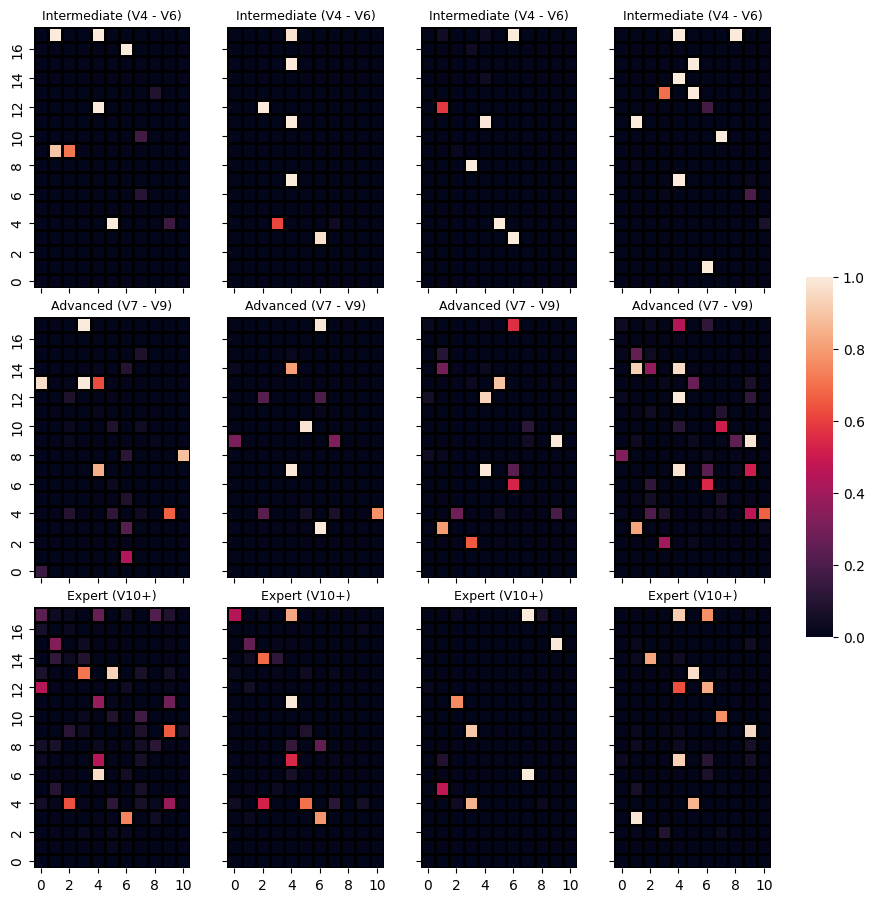

Epoch: 81 | Epoch Time: 0m 6s | Generator Loss: 0.071 | Discriminator Loss: -0.017


Epoch: 82 | Epoch Time: 0m 5s | Generator Loss: 0.072 | Discriminator Loss: -0.018


Epoch: 83 | Epoch Time: 0m 4s | Generator Loss: 0.076 | Discriminator Loss: -0.016


Epoch: 84 | Epoch Time: 0m 5s | Generator Loss: 0.075 | Discriminator Loss: -0.016


Epoch: 85 | Epoch Time: 0m 5s | Generator Loss: 0.078 | Discriminator Loss: -0.019


Epoch: 86 | Epoch Time: 0m 4s | Generator Loss: 0.080 | Discriminator Loss: -0.019


Epoch: 87 | Epoch Time: 0m 5s | Generator Loss: 0.081 | Discriminator Loss: -0.019


Epoch: 88 | Epoch Time: 0m 5s | Generator Loss: 0.083 | Discriminator Loss: -0.017


Epoch: 89 | Epoch Time: 0m 4s | Generator Loss: 0.083 | Discriminator Loss: -0.019


Epoch: 90 | Epoch Time: 0m 5s | Generator Loss: 0.080 | Discriminator Loss: -0.014
Checkpoint 9 - generated board probability maps (with same latent generation): 


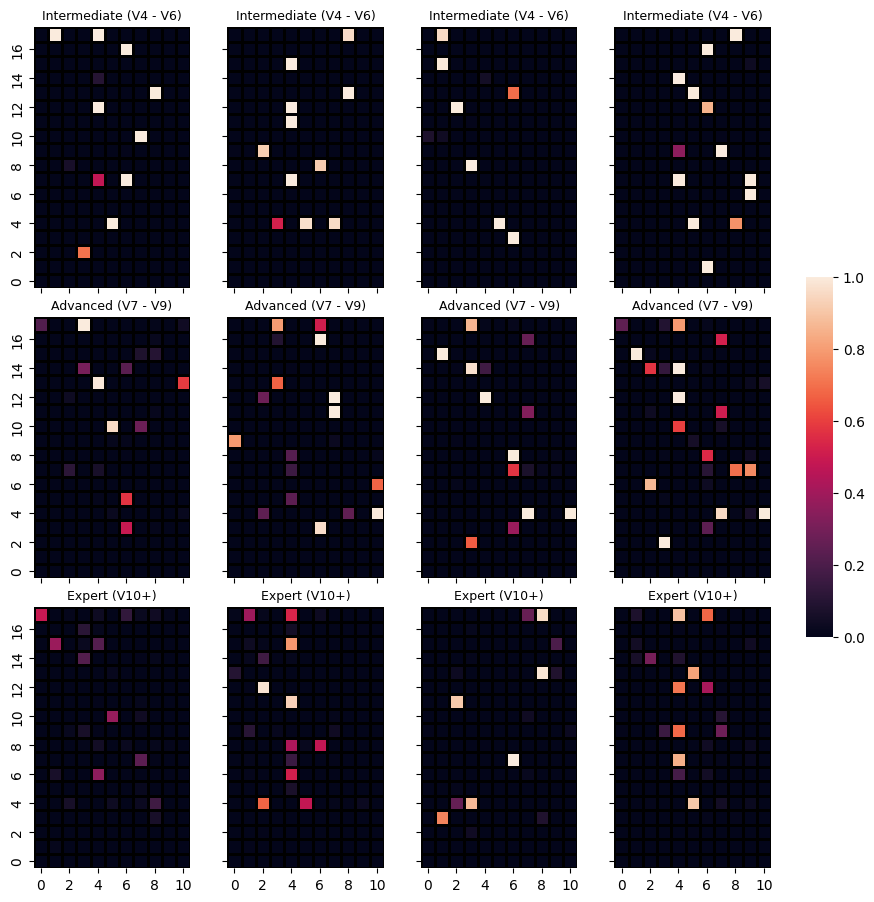

Epoch: 91 | Epoch Time: 0m 6s | Generator Loss: 0.082 | Discriminator Loss: -0.017


Epoch: 92 | Epoch Time: 0m 4s | Generator Loss: 0.087 | Discriminator Loss: -0.017


Epoch: 93 | Epoch Time: 0m 5s | Generator Loss: 0.084 | Discriminator Loss: -0.021


Epoch: 94 | Epoch Time: 0m 5s | Generator Loss: 0.085 | Discriminator Loss: -0.019


Epoch: 95 | Epoch Time: 0m 4s | Generator Loss: 0.085 | Discriminator Loss: -0.017


Epoch: 96 | Epoch Time: 0m 5s | Generator Loss: 0.089 | Discriminator Loss: -0.019


Epoch: 97 | Epoch Time: 0m 5s | Generator Loss: 0.089 | Discriminator Loss: -0.024


Epoch: 98 | Epoch Time: 0m 4s | Generator Loss: 0.086 | Discriminator Loss: -0.020


Epoch: 99 | Epoch Time: 0m 5s | Generator Loss: 0.090 | Discriminator Loss: -0.020


Epoch: 100 | Epoch Time: 0m 5s | Generator Loss: 0.091 | Discriminator Loss: -0.021
Checkpoint 10 - generated board probability maps (with same latent generation): 


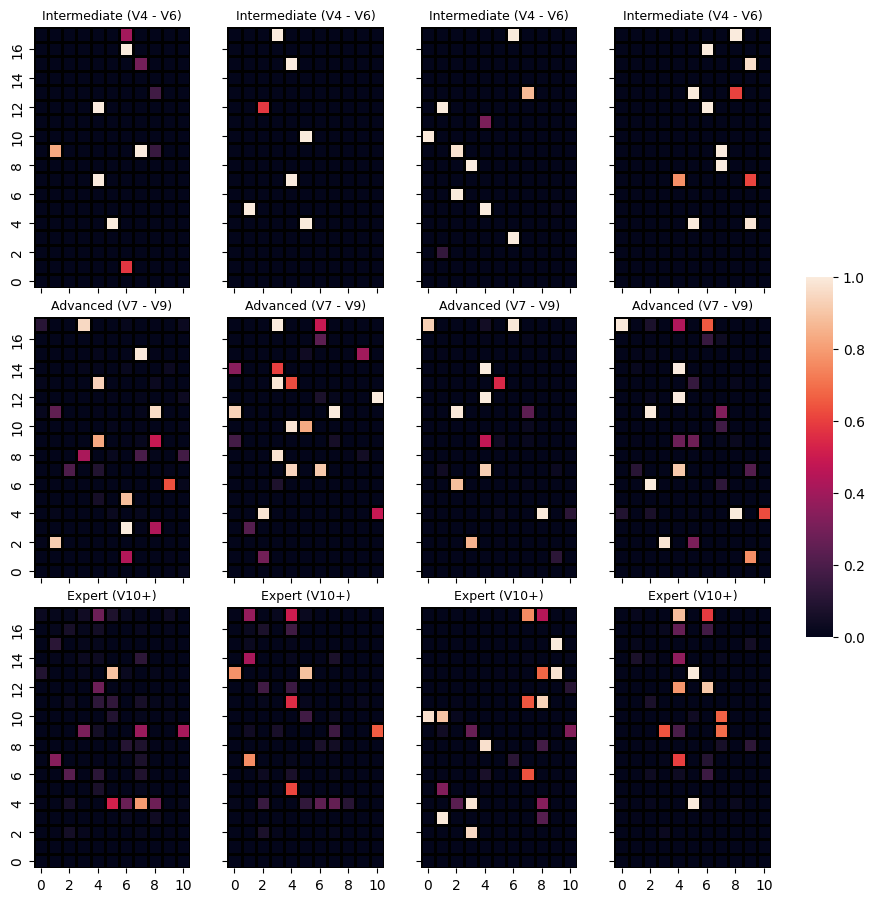

Epoch: 101 | Epoch Time: 0m 6s | Generator Loss: 0.092 | Discriminator Loss: -0.019


Epoch: 102 | Epoch Time: 0m 4s | Generator Loss: 0.097 | Discriminator Loss: -0.018


Epoch: 103 | Epoch Time: 0m 5s | Generator Loss: 0.097 | Discriminator Loss: -0.020


Epoch: 104 | Epoch Time: 0m 5s | Generator Loss: 0.101 | Discriminator Loss: -0.020


Epoch: 105 | Epoch Time: 0m 5s | Generator Loss: 0.096 | Discriminator Loss: -0.024


Epoch: 106 | Epoch Time: 0m 5s | Generator Loss: 0.091 | Discriminator Loss: -0.020


Epoch: 107 | Epoch Time: 0m 5s | Generator Loss: 0.095 | Discriminator Loss: -0.021


Epoch: 108 | Epoch Time: 0m 4s | Generator Loss: 0.098 | Discriminator Loss: -0.027


Epoch: 109 | Epoch Time: 0m 5s | Generator Loss: 0.103 | Discriminator Loss: -0.030


Epoch: 110 | Epoch Time: 0m 5s | Generator Loss: 0.098 | Discriminator Loss: -0.028
Checkpoint 11 - generated board probability maps (with same latent generation): 


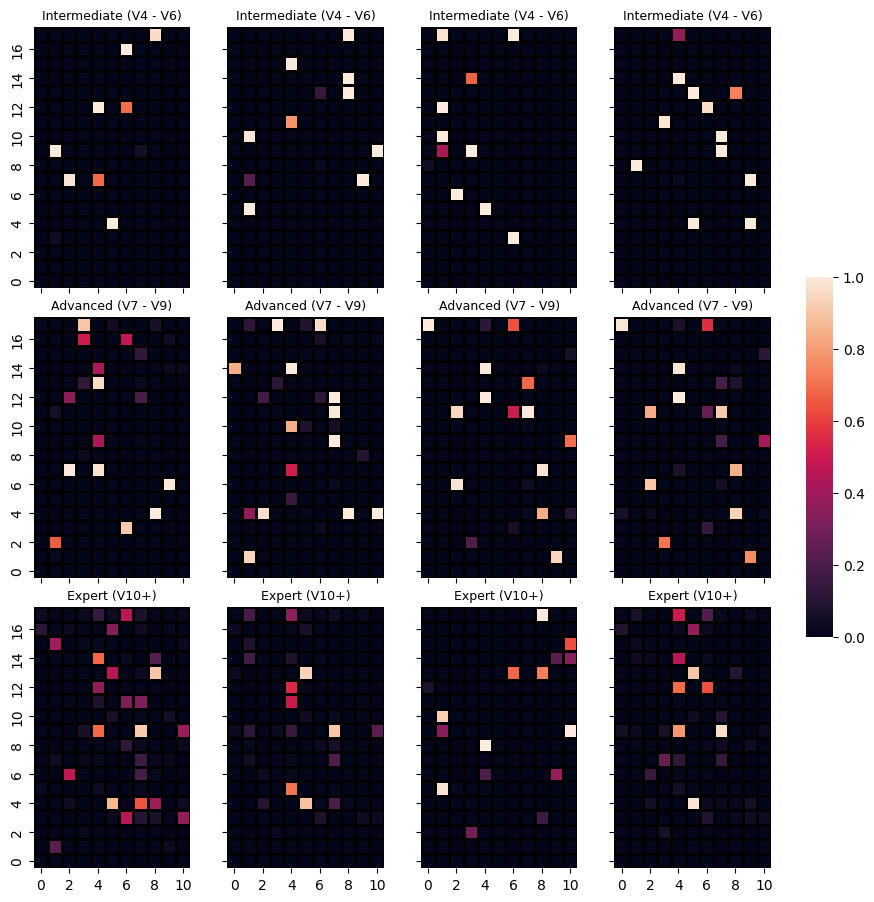

Epoch: 111 | Epoch Time: 0m 6s | Generator Loss: 0.101 | Discriminator Loss: -0.022


Epoch: 112 | Epoch Time: 0m 5s | Generator Loss: 0.095 | Discriminator Loss: -0.017


Epoch: 113 | Epoch Time: 0m 5s | Generator Loss: 0.103 | Discriminator Loss: -0.018


Epoch: 114 | Epoch Time: 0m 5s | Generator Loss: 0.104 | Discriminator Loss: -0.023


Epoch: 115 | Epoch Time: 0m 5s | Generator Loss: 0.109 | Discriminator Loss: -0.023


Epoch: 116 | Epoch Time: 0m 5s | Generator Loss: 0.109 | Discriminator Loss: -0.019


Epoch: 117 | Epoch Time: 0m 4s | Generator Loss: 0.111 | Discriminator Loss: -0.021


Epoch: 118 | Epoch Time: 0m 5s | Generator Loss: 0.110 | Discriminator Loss: -0.025


Epoch: 119 | Epoch Time: 0m 5s | Generator Loss: 0.103 | Discriminator Loss: -0.025


Epoch: 120 | Epoch Time: 0m 4s | Generator Loss: 0.103 | Discriminator Loss: -0.016
Checkpoint 12 - generated board probability maps (with same latent generation): 


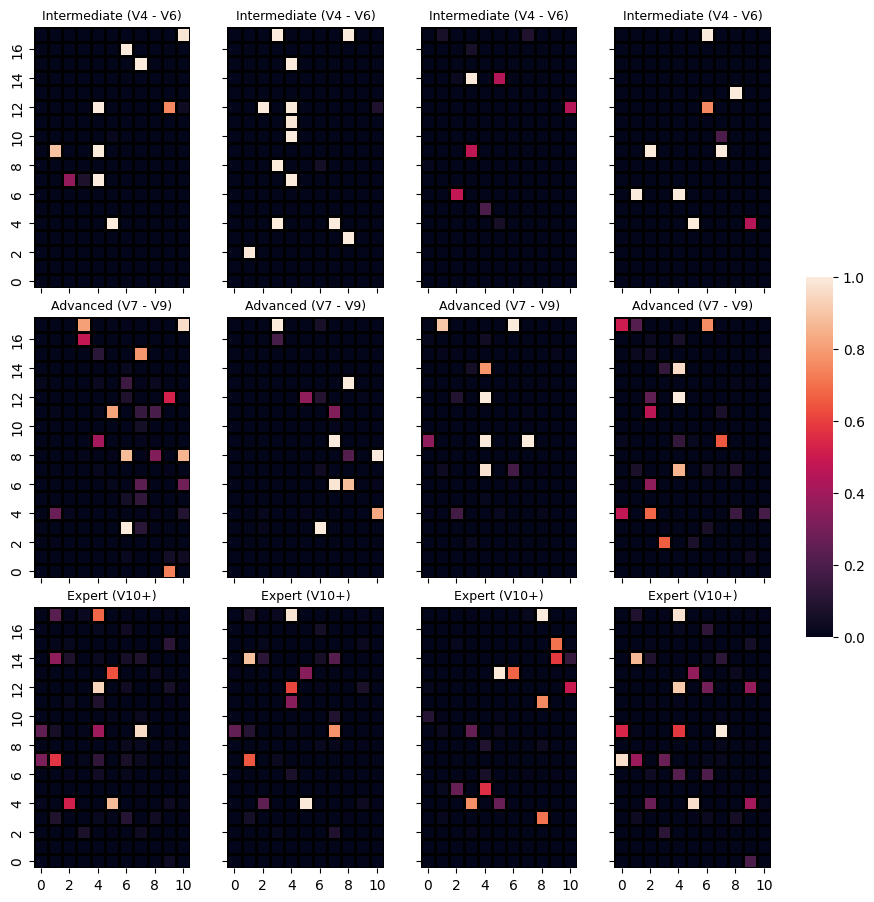

Epoch: 121 | Epoch Time: 0m 6s | Generator Loss: 0.107 | Discriminator Loss: -0.015


Epoch: 122 | Epoch Time: 0m 5s | Generator Loss: 0.109 | Discriminator Loss: -0.017


Epoch: 123 | Epoch Time: 0m 5s | Generator Loss: 0.106 | Discriminator Loss: -0.018


Epoch: 124 | Epoch Time: 0m 5s | Generator Loss: 0.099 | Discriminator Loss: -0.013


Epoch: 125 | Epoch Time: 0m 5s | Generator Loss: 0.106 | Discriminator Loss: -0.016


Epoch: 126 | Epoch Time: 0m 5s | Generator Loss: 0.110 | Discriminator Loss: -0.015


Epoch: 127 | Epoch Time: 0m 5s | Generator Loss: 0.109 | Discriminator Loss: -0.017


Epoch: 128 | Epoch Time: 0m 5s | Generator Loss: 0.110 | Discriminator Loss: -0.019


Epoch: 129 | Epoch Time: 0m 5s | Generator Loss: 0.113 | Discriminator Loss: -0.019


Epoch: 130 | Epoch Time: 0m 4s | Generator Loss: 0.116 | Discriminator Loss: -0.021
Checkpoint 13 - generated board probability maps (with same latent generation): 


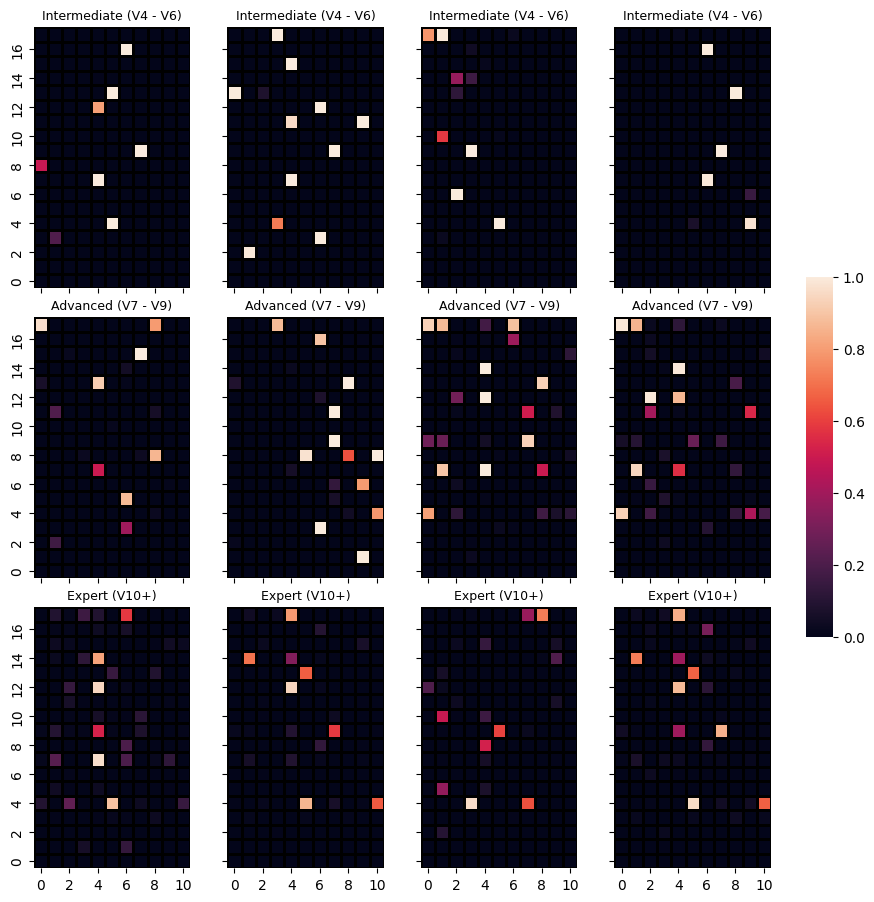

Epoch: 131 | Epoch Time: 0m 6s | Generator Loss: 0.119 | Discriminator Loss: -0.022


Epoch: 132 | Epoch Time: 0m 5s | Generator Loss: 0.126 | Discriminator Loss: -0.023


Epoch: 133 | Epoch Time: 0m 5s | Generator Loss: 0.124 | Discriminator Loss: -0.025


Epoch: 134 | Epoch Time: 0m 5s | Generator Loss: 0.126 | Discriminator Loss: -0.020


Epoch: 135 | Epoch Time: 0m 5s | Generator Loss: 0.118 | Discriminator Loss: -0.017


Epoch: 136 | Epoch Time: 0m 4s | Generator Loss: 0.120 | Discriminator Loss: -0.017


Epoch: 137 | Epoch Time: 0m 5s | Generator Loss: 0.121 | Discriminator Loss: -0.019


Epoch: 138 | Epoch Time: 0m 5s | Generator Loss: 0.120 | Discriminator Loss: -0.021


Epoch: 139 | Epoch Time: 0m 4s | Generator Loss: 0.125 | Discriminator Loss: -0.022


Epoch: 140 | Epoch Time: 0m 4s | Generator Loss: 0.127 | Discriminator Loss: -0.023
Checkpoint 14 - generated board probability maps (with same latent generation): 


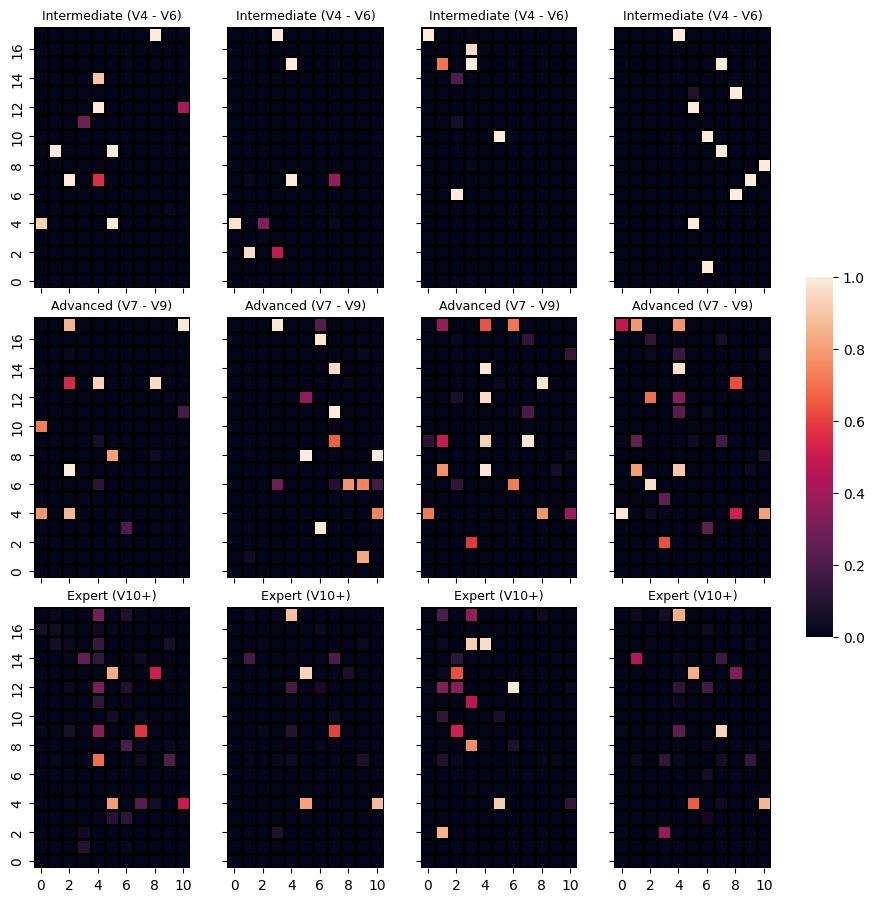

Epoch: 141 | Epoch Time: 0m 6s | Generator Loss: 0.129 | Discriminator Loss: -0.020


Epoch: 142 | Epoch Time: 0m 4s | Generator Loss: 0.129 | Discriminator Loss: -0.027


Epoch: 143 | Epoch Time: 0m 5s | Generator Loss: 0.134 | Discriminator Loss: -0.027


Epoch: 144 | Epoch Time: 0m 5s | Generator Loss: 0.121 | Discriminator Loss: -0.017


Epoch: 145 | Epoch Time: 0m 4s | Generator Loss: 0.130 | Discriminator Loss: -0.018


Epoch: 146 | Epoch Time: 0m 5s | Generator Loss: 0.134 | Discriminator Loss: -0.020


Epoch: 147 | Epoch Time: 0m 5s | Generator Loss: 0.136 | Discriminator Loss: -0.021


Epoch: 148 | Epoch Time: 0m 4s | Generator Loss: 0.138 | Discriminator Loss: -0.027


Epoch: 149 | Epoch Time: 0m 4s | Generator Loss: 0.144 | Discriminator Loss: -0.021


Epoch: 150 | Epoch Time: 0m 5s | Generator Loss: 0.143 | Discriminator Loss: -0.024
Checkpoint 15 - generated board probability maps (with same latent generation): 


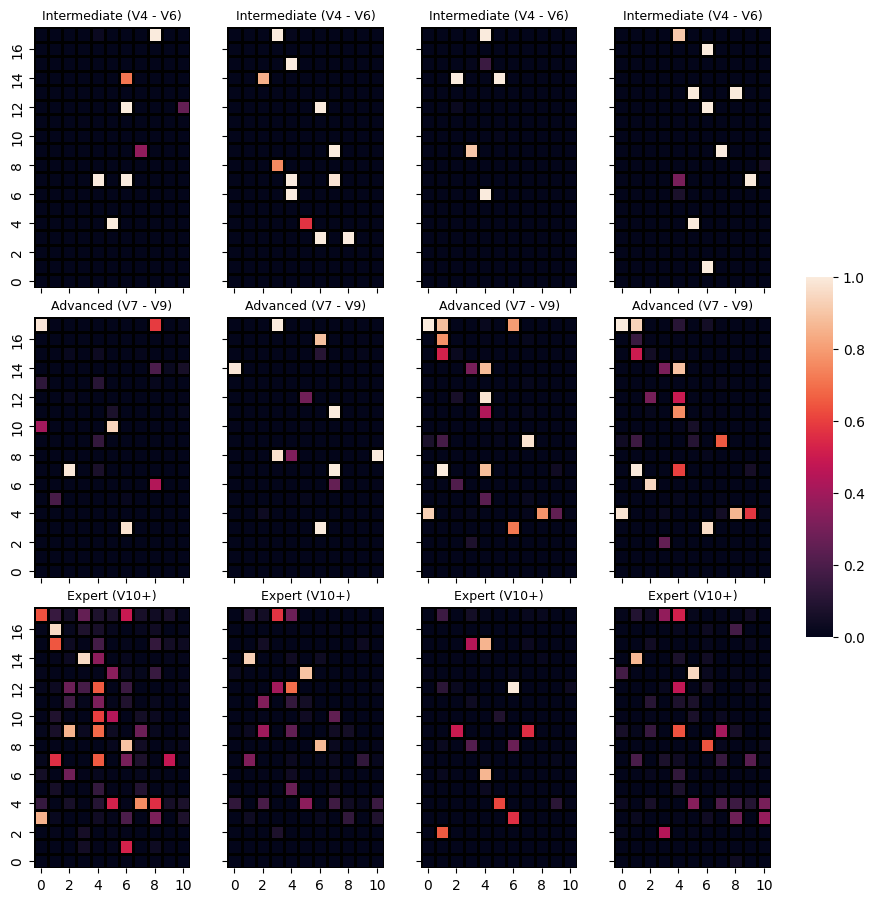

Epoch: 151 | Epoch Time: 0m 6s | Generator Loss: 0.147 | Discriminator Loss: -0.022


Epoch: 152 | Epoch Time: 0m 5s | Generator Loss: 0.145 | Discriminator Loss: -0.029


Epoch: 153 | Epoch Time: 0m 5s | Generator Loss: 0.022 | Discriminator Loss: 25.782


Epoch: 154 | Epoch Time: 0m 5s | Generator Loss: -0.254 | Discriminator Loss: 0.284


Epoch: 155 | Epoch Time: 0m 4s | Generator Loss: 0.081 | Discriminator Loss: -0.066


Epoch: 156 | Epoch Time: 0m 5s | Generator Loss: 0.133 | Discriminator Loss: -0.116


Epoch: 157 | Epoch Time: 0m 5s | Generator Loss: 0.087 | Discriminator Loss: -0.057


Epoch: 158 | Epoch Time: 0m 4s | Generator Loss: 0.055 | Discriminator Loss: -0.059


Epoch: 159 | Epoch Time: 0m 5s | Generator Loss: 0.087 | Discriminator Loss: -0.067


Epoch: 160 | Epoch Time: 0m 4s | Generator Loss: 0.109 | Discriminator Loss: -0.054
Checkpoint 16 - generated board probability maps (with same latent generation): 


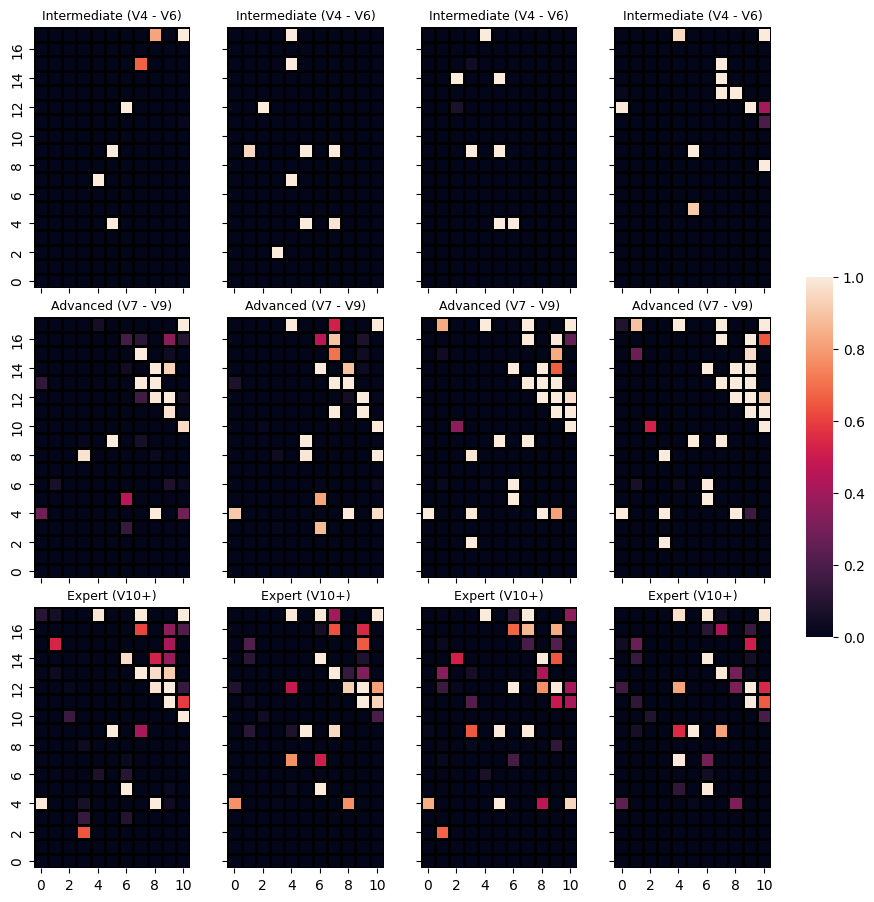

Epoch: 161 | Epoch Time: 0m 6s | Generator Loss: 0.116 | Discriminator Loss: -0.042


Epoch: 162 | Epoch Time: 0m 5s | Generator Loss: 0.123 | Discriminator Loss: -0.044


Epoch: 163 | Epoch Time: 0m 5s | Generator Loss: 0.135 | Discriminator Loss: -0.022


Epoch: 164 | Epoch Time: 0m 4s | Generator Loss: 0.140 | Discriminator Loss: -0.024


Epoch: 165 | Epoch Time: 0m 4s | Generator Loss: 0.142 | Discriminator Loss: -0.019


Epoch: 166 | Epoch Time: 0m 5s | Generator Loss: 0.145 | Discriminator Loss: -0.022


Epoch: 167 | Epoch Time: 0m 4s | Generator Loss: 0.146 | Discriminator Loss: -0.018


Epoch: 168 | Epoch Time: 0m 4s | Generator Loss: 0.142 | Discriminator Loss: -0.017


Epoch: 169 | Epoch Time: 0m 5s | Generator Loss: 0.152 | Discriminator Loss: -0.020


Epoch: 170 | Epoch Time: 0m 5s | Generator Loss: 0.145 | Discriminator Loss: -0.024
Checkpoint 17 - generated board probability maps (with same latent generation): 


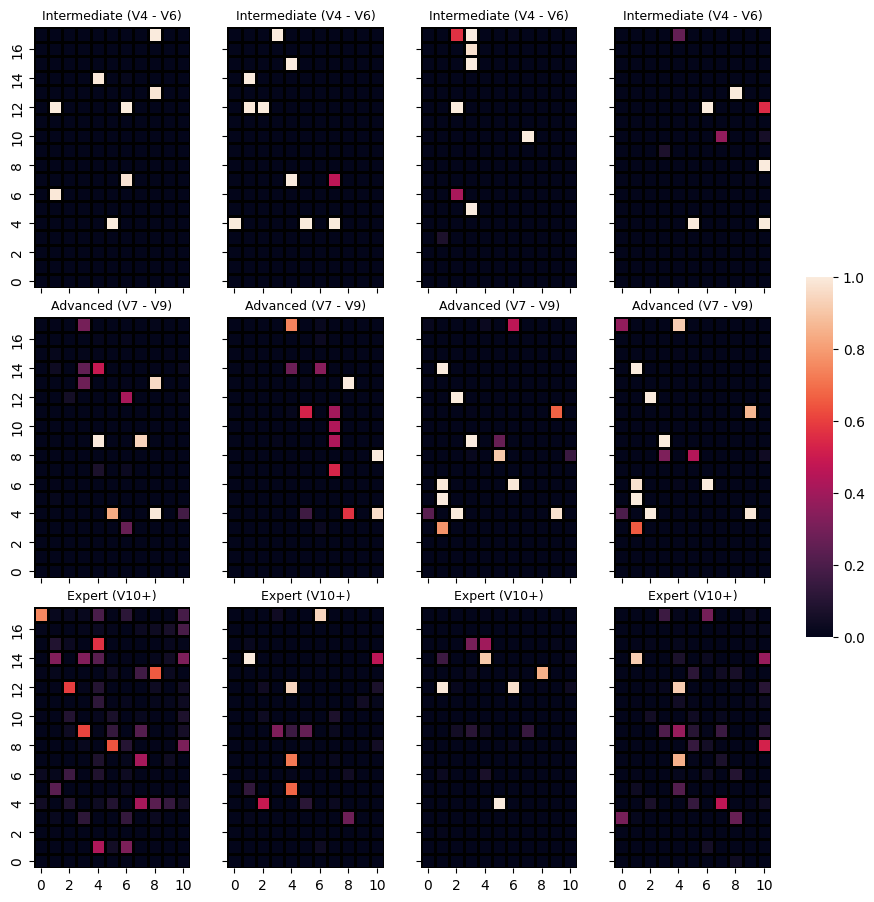

Epoch: 171 | Epoch Time: 0m 6s | Generator Loss: 0.144 | Discriminator Loss: -0.028


Epoch: 172 | Epoch Time: 0m 5s | Generator Loss: 0.152 | Discriminator Loss: 0.001


Epoch: 173 | Epoch Time: 0m 4s | Generator Loss: 0.150 | Discriminator Loss: -0.018


Epoch: 174 | Epoch Time: 0m 4s | Generator Loss: 0.148 | Discriminator Loss: -0.018


Epoch: 175 | Epoch Time: 0m 5s | Generator Loss: 0.145 | Discriminator Loss: -0.018


Epoch: 176 | Epoch Time: 0m 5s | Generator Loss: 0.144 | Discriminator Loss: -0.025


Epoch: 177 | Epoch Time: 0m 4s | Generator Loss: 0.142 | Discriminator Loss: -0.023


Epoch: 178 | Epoch Time: 0m 5s | Generator Loss: 0.143 | Discriminator Loss: -0.025


Epoch: 179 | Epoch Time: 0m 4s | Generator Loss: 0.140 | Discriminator Loss: -0.024


Epoch: 180 | Epoch Time: 0m 5s | Generator Loss: 0.135 | Discriminator Loss: -0.030
Checkpoint 18 - generated board probability maps (with same latent generation): 


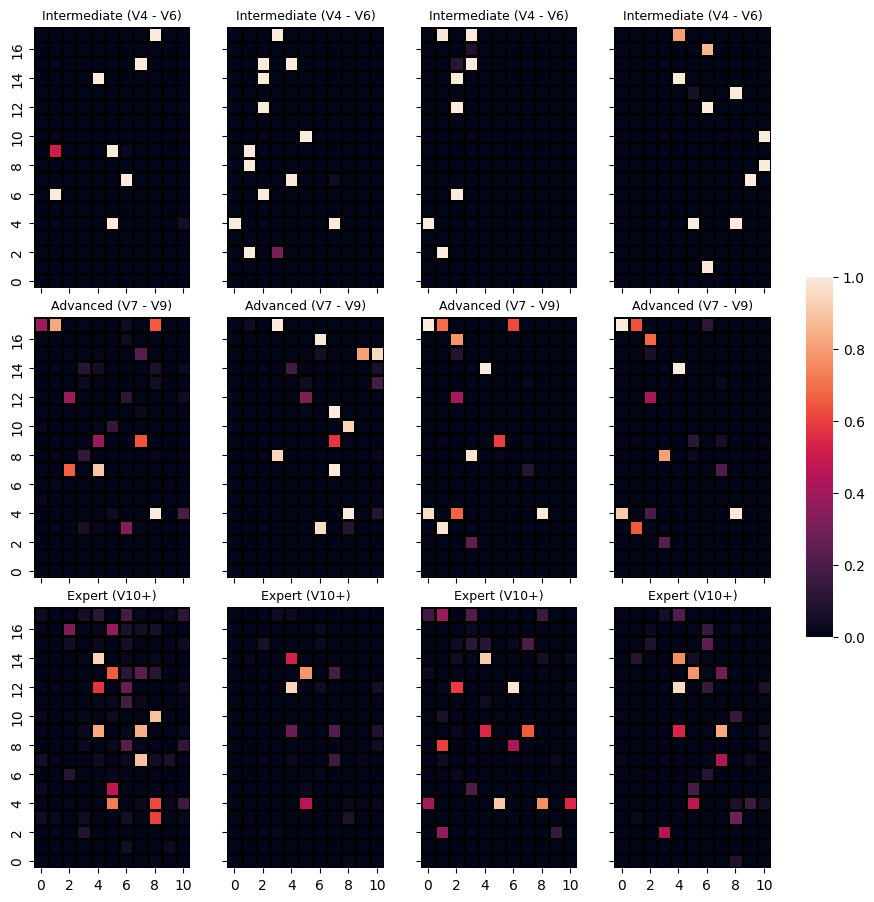

Epoch: 181 | Epoch Time: 0m 6s | Generator Loss: 0.138 | Discriminator Loss: -0.029


Epoch: 182 | Epoch Time: 0m 5s | Generator Loss: 0.133 | Discriminator Loss: -0.007


Epoch: 183 | Epoch Time: 0m 4s | Generator Loss: 0.139 | Discriminator Loss: -0.032


Epoch: 184 | Epoch Time: 0m 5s | Generator Loss: 0.138 | Discriminator Loss: -0.027


Epoch: 185 | Epoch Time: 0m 5s | Generator Loss: 0.143 | Discriminator Loss: -0.033


Epoch: 186 | Epoch Time: 0m 4s | Generator Loss: 0.144 | Discriminator Loss: -0.028


Epoch: 187 | Epoch Time: 0m 4s | Generator Loss: 0.135 | Discriminator Loss: -0.033


Epoch: 188 | Epoch Time: 0m 5s | Generator Loss: 0.138 | Discriminator Loss: -0.040


Epoch: 189 | Epoch Time: 0m 5s | Generator Loss: 0.135 | Discriminator Loss: -0.053


Epoch: 190 | Epoch Time: 0m 4s | Generator Loss: 0.130 | Discriminator Loss: -0.008
Checkpoint 19 - generated board probability maps (with same latent generation): 


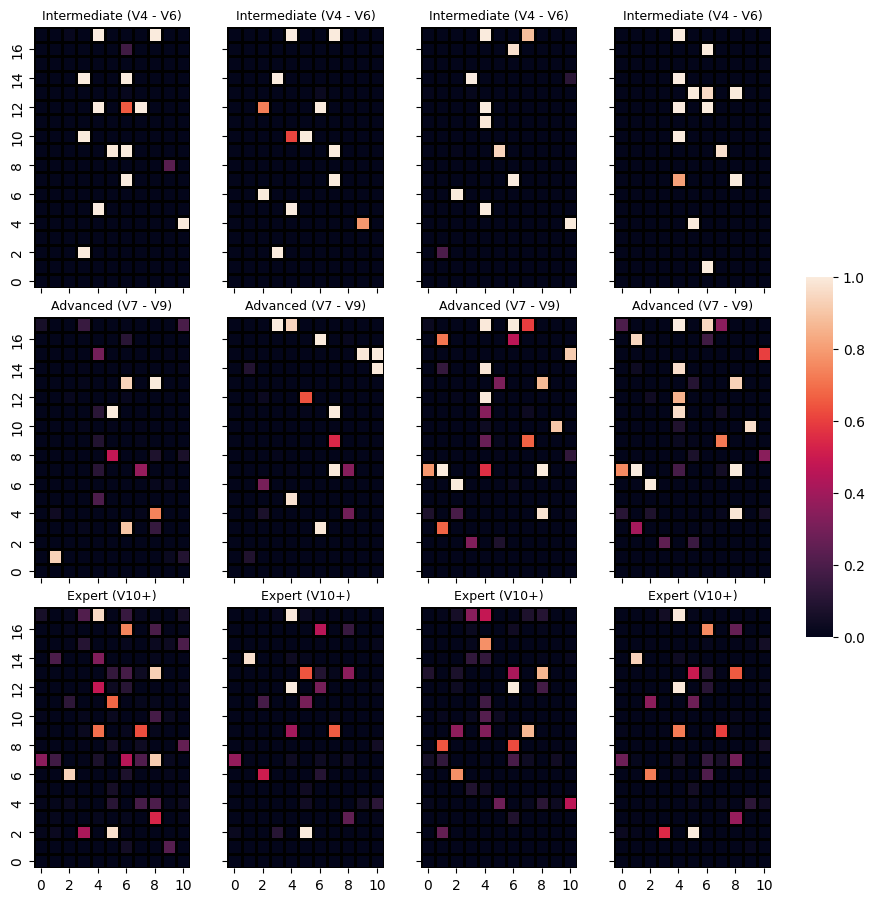

Epoch: 191 | Epoch Time: 0m 6s | Generator Loss: 0.133 | Discriminator Loss: -0.036


Epoch: 192 | Epoch Time: 0m 4s | Generator Loss: 0.135 | Discriminator Loss: -0.024


Epoch: 193 | Epoch Time: 0m 4s | Generator Loss: 0.131 | Discriminator Loss: -0.031


Epoch: 194 | Epoch Time: 0m 5s | Generator Loss: 0.137 | Discriminator Loss: -0.030


Epoch: 195 | Epoch Time: 0m 5s | Generator Loss: 0.135 | Discriminator Loss: -0.057


Epoch: 196 | Epoch Time: 0m 4s | Generator Loss: 0.144 | Discriminator Loss: -0.062


Epoch: 197 | Epoch Time: 0m 5s | Generator Loss: 0.147 | Discriminator Loss: -0.052


Epoch: 198 | Epoch Time: 0m 5s | Generator Loss: 0.141 | Discriminator Loss: -0.060


Epoch: 199 | Epoch Time: 0m 4s | Generator Loss: 0.137 | Discriminator Loss: -0.057


Epoch: 200 | Epoch Time: 0m 5s | Generator Loss: 0.141 | Discriminator Loss: -0.077
Checkpoint 20 - generated board probability maps (with same latent generation): 


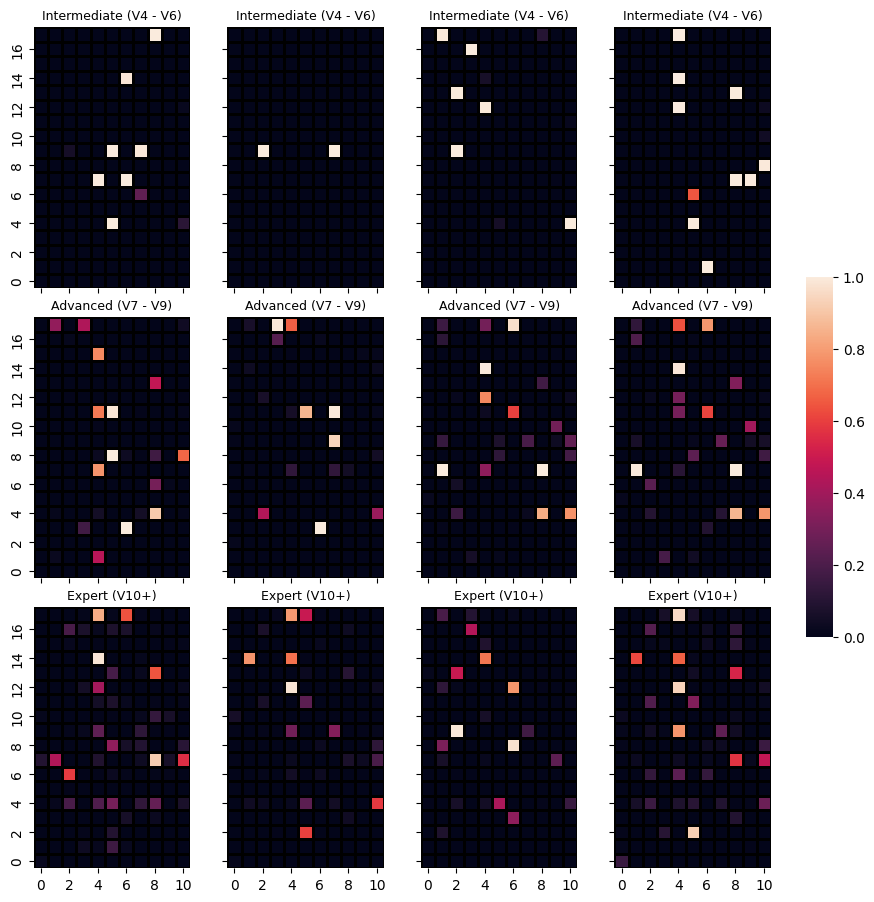

Epoch: 201 | Epoch Time: 0m 6s | Generator Loss: 0.131 | Discriminator Loss: -0.051


Epoch: 202 | Epoch Time: 0m 4s | Generator Loss: 0.137 | Discriminator Loss: 0.001


Epoch: 203 | Epoch Time: 0m 5s | Generator Loss: 0.145 | Discriminator Loss: -0.017


Epoch: 204 | Epoch Time: 0m 5s | Generator Loss: 0.138 | Discriminator Loss: -0.025


Epoch: 205 | Epoch Time: 0m 4s | Generator Loss: 0.135 | Discriminator Loss: -0.022


Epoch: 206 | Epoch Time: 0m 5s | Generator Loss: 0.134 | Discriminator Loss: -0.021


Epoch: 207 | Epoch Time: 0m 5s | Generator Loss: 0.142 | Discriminator Loss: -0.022


Epoch: 208 | Epoch Time: 0m 5s | Generator Loss: 0.138 | Discriminator Loss: -0.031


Epoch: 209 | Epoch Time: 0m 5s | Generator Loss: 0.139 | Discriminator Loss: -0.015


Epoch: 210 | Epoch Time: 0m 4s | Generator Loss: 0.141 | Discriminator Loss: -0.006
Checkpoint 21 - generated board probability maps (with same latent generation): 


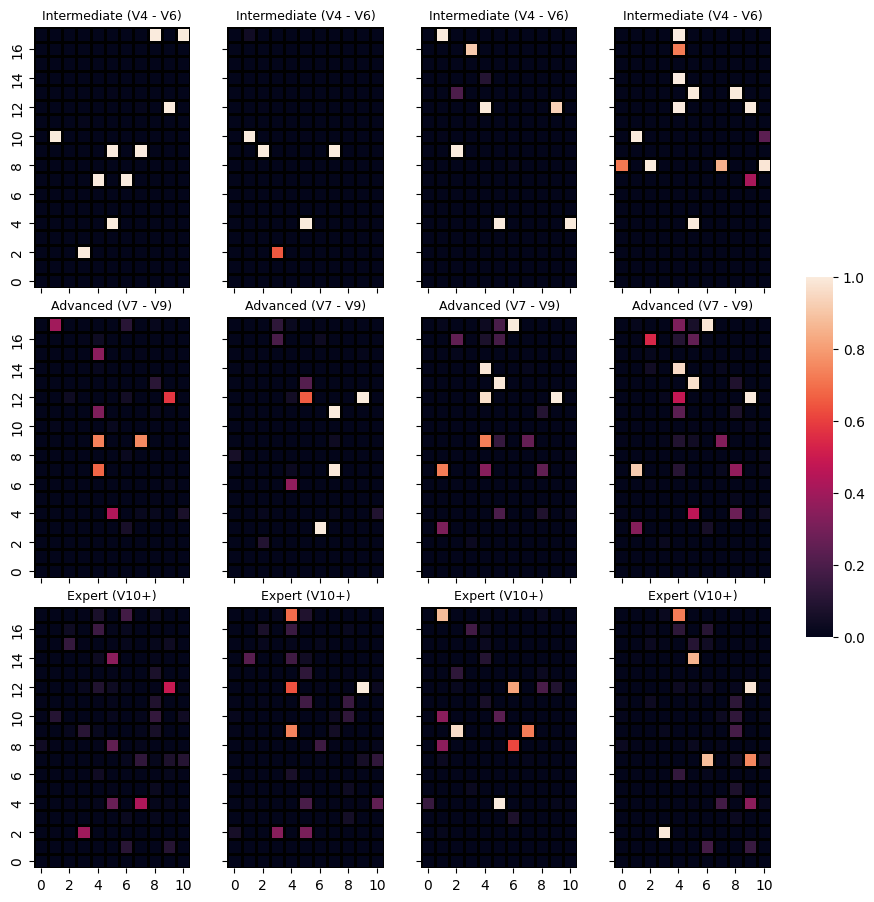

Epoch: 211 | Epoch Time: 0m 6s | Generator Loss: 0.137 | Discriminator Loss: -0.022


Epoch: 212 | Epoch Time: 0m 4s | Generator Loss: 0.135 | Discriminator Loss: -0.025


Epoch: 213 | Epoch Time: 0m 5s | Generator Loss: 0.130 | Discriminator Loss: -0.017


Epoch: 214 | Epoch Time: 0m 5s | Generator Loss: 0.130 | Discriminator Loss: -0.024


Epoch: 215 | Epoch Time: 0m 4s | Generator Loss: 0.143 | Discriminator Loss: -0.018


Epoch: 216 | Epoch Time: 0m 4s | Generator Loss: 0.138 | Discriminator Loss: -0.028


Epoch: 217 | Epoch Time: 0m 5s | Generator Loss: 0.143 | Discriminator Loss: -0.027


Epoch: 218 | Epoch Time: 0m 4s | Generator Loss: 0.142 | Discriminator Loss: -0.035


Epoch: 219 | Epoch Time: 0m 5s | Generator Loss: 0.143 | Discriminator Loss: -0.036


Epoch: 220 | Epoch Time: 0m 5s | Generator Loss: 0.147 | Discriminator Loss: -0.033
Checkpoint 22 - generated board probability maps (with same latent generation): 


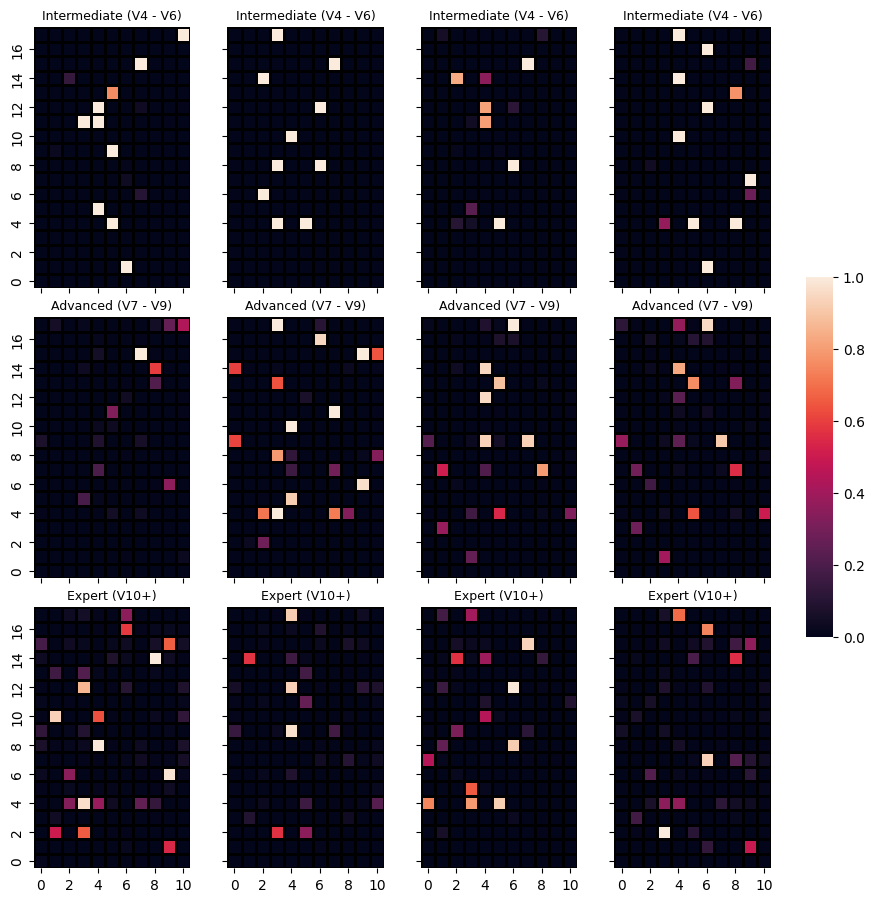

Epoch: 221 | Epoch Time: 0m 6s | Generator Loss: 0.143 | Discriminator Loss: -0.041


Epoch: 222 | Epoch Time: 0m 5s | Generator Loss: 0.148 | Discriminator Loss: -0.029


Epoch: 223 | Epoch Time: 0m 5s | Generator Loss: 0.142 | Discriminator Loss: -0.031


Epoch: 224 | Epoch Time: 0m 4s | Generator Loss: 0.143 | Discriminator Loss: -0.030


Epoch: 225 | Epoch Time: 0m 4s | Generator Loss: 0.149 | Discriminator Loss: -0.044


Epoch: 226 | Epoch Time: 0m 5s | Generator Loss: 0.159 | Discriminator Loss: -0.059


Epoch: 227 | Epoch Time: 0m 4s | Generator Loss: 0.152 | Discriminator Loss: -0.075


Epoch: 228 | Epoch Time: 0m 4s | Generator Loss: 0.153 | Discriminator Loss: -0.046


Epoch: 229 | Epoch Time: 0m 5s | Generator Loss: 0.155 | Discriminator Loss: -0.087


Epoch: 230 | Epoch Time: 0m 4s | Generator Loss: 0.141 | Discriminator Loss: -0.050
Checkpoint 23 - generated board probability maps (with same latent generation): 


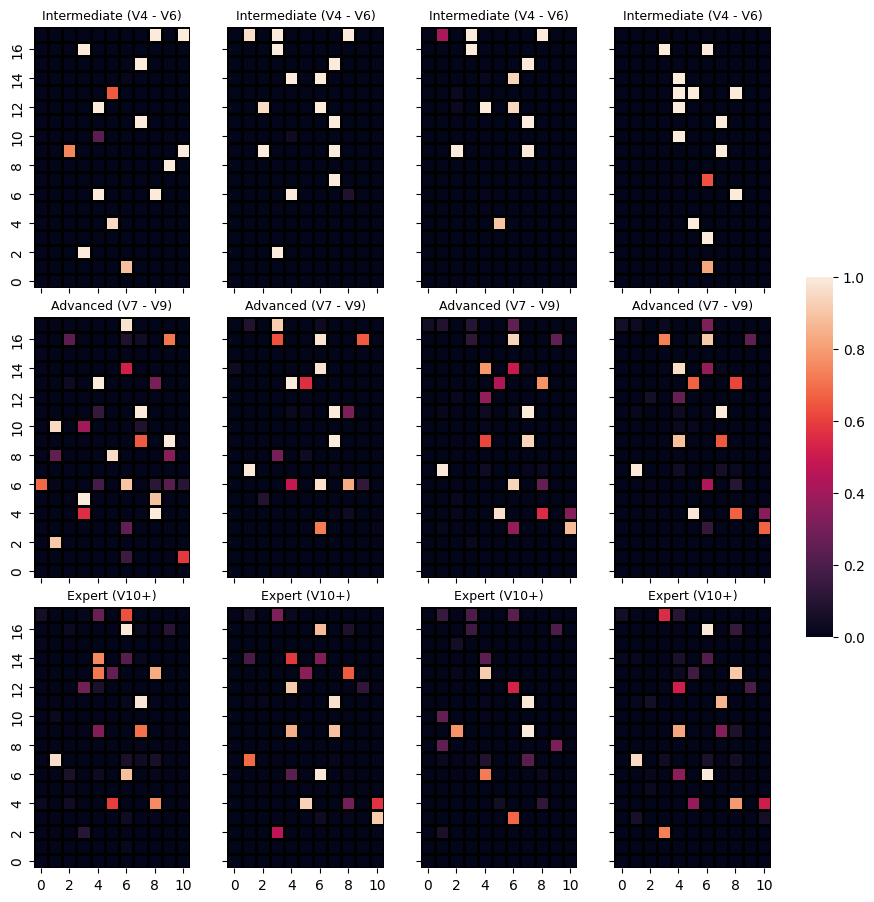

Epoch: 231 | Epoch Time: 0m 6s | Generator Loss: 0.144 | Discriminator Loss: -0.010


Epoch: 232 | Epoch Time: 0m 5s | Generator Loss: 0.140 | Discriminator Loss: 0.023


Epoch: 233 | Epoch Time: 0m 5s | Generator Loss: 0.148 | Discriminator Loss: -0.073


Epoch: 234 | Epoch Time: 0m 5s | Generator Loss: 0.145 | Discriminator Loss: -0.098


Epoch: 235 | Epoch Time: 0m 5s | Generator Loss: 0.134 | Discriminator Loss: -0.130


Epoch: 236 | Epoch Time: 0m 4s | Generator Loss: 0.140 | Discriminator Loss: -0.127


Epoch: 237 | Epoch Time: 0m 5s | Generator Loss: 0.139 | Discriminator Loss: -0.150


Epoch: 238 | Epoch Time: 0m 5s | Generator Loss: 0.146 | Discriminator Loss: -0.065


Epoch: 239 | Epoch Time: 0m 5s | Generator Loss: 0.157 | Discriminator Loss: -0.026


Epoch: 240 | Epoch Time: 0m 4s | Generator Loss: 0.147 | Discriminator Loss: -0.022
Checkpoint 24 - generated board probability maps (with same latent generation): 


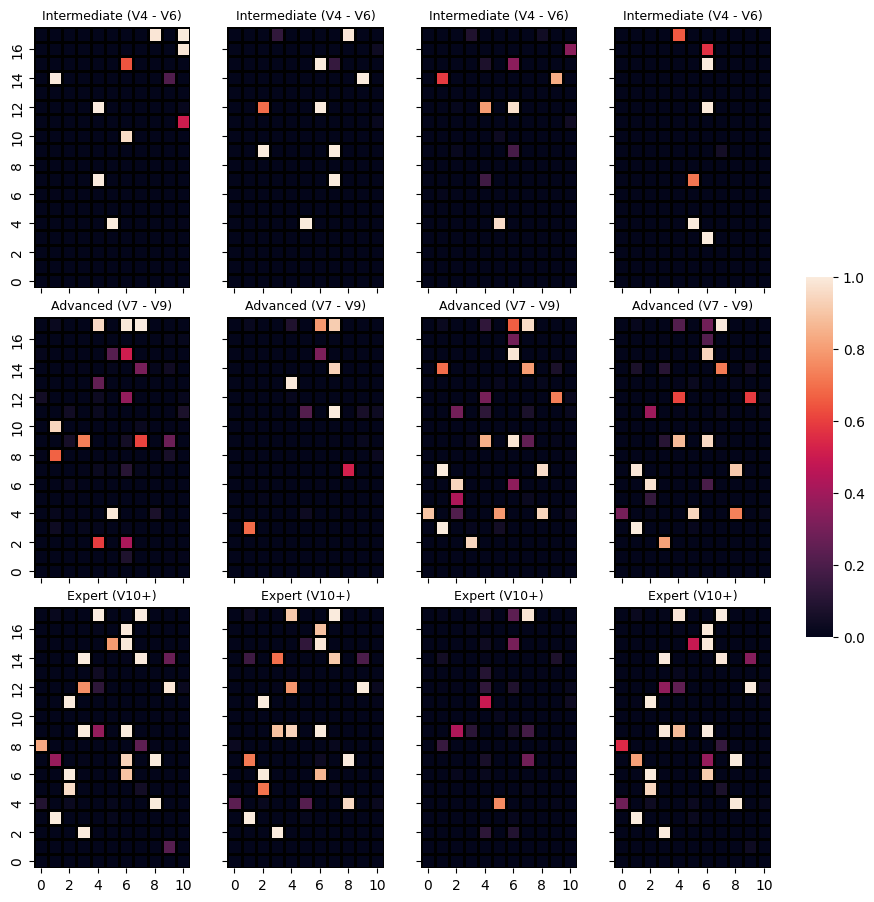

Epoch: 241 | Epoch Time: 0m 6s | Generator Loss: 0.155 | Discriminator Loss: -0.030


Epoch: 242 | Epoch Time: 0m 5s | Generator Loss: 0.144 | Discriminator Loss: -0.047


Epoch: 243 | Epoch Time: 0m 4s | Generator Loss: 0.150 | Discriminator Loss: -0.057


Epoch: 244 | Epoch Time: 0m 4s | Generator Loss: 0.153 | Discriminator Loss: -0.030


Epoch: 245 | Epoch Time: 0m 5s | Generator Loss: 0.130 | Discriminator Loss: -0.085


Epoch: 246 | Epoch Time: 0m 5s | Generator Loss: 0.168 | Discriminator Loss: -0.077


Epoch: 247 | Epoch Time: 0m 5s | Generator Loss: 0.114 | Discriminator Loss: -0.087


Epoch: 248 | Epoch Time: 0m 5s | Generator Loss: 0.111 | Discriminator Loss: -0.112


Epoch: 249 | Epoch Time: 0m 4s | Generator Loss: 0.124 | Discriminator Loss: -0.106


Epoch: 250 | Epoch Time: 0m 4s | Generator Loss: 0.126 | Discriminator Loss: 0.000
Checkpoint 25 - generated board probability maps (with same latent generation): 


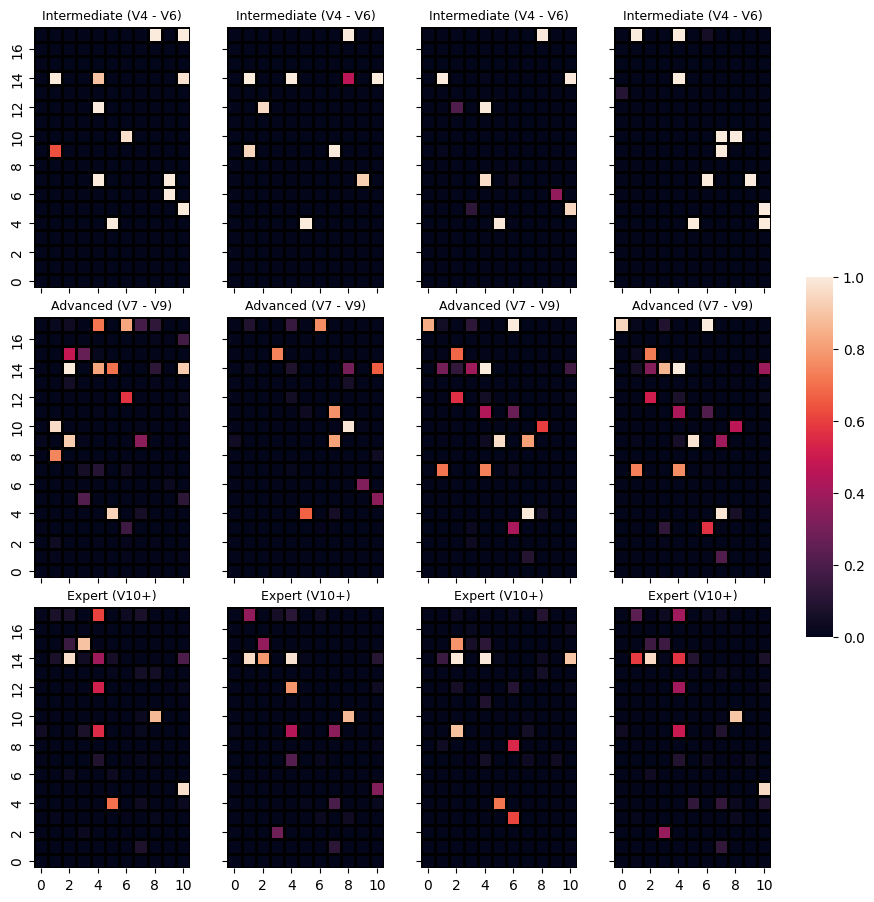

Epoch: 251 | Epoch Time: 0m 6s | Generator Loss: 0.132 | Discriminator Loss: -0.024


Epoch: 252 | Epoch Time: 0m 5s | Generator Loss: 0.119 | Discriminator Loss: -0.039


Epoch: 253 | Epoch Time: 0m 4s | Generator Loss: 0.117 | Discriminator Loss: -0.020


Epoch: 254 | Epoch Time: 0m 5s | Generator Loss: 0.119 | Discriminator Loss: -0.041


Epoch: 255 | Epoch Time: 0m 5s | Generator Loss: 0.102 | Discriminator Loss: -0.072


Epoch: 256 | Epoch Time: 0m 5s | Generator Loss: 0.105 | Discriminator Loss: -0.024


Epoch: 257 | Epoch Time: 0m 5s | Generator Loss: 0.107 | Discriminator Loss: -0.051


Epoch: 258 | Epoch Time: 0m 5s | Generator Loss: 0.104 | Discriminator Loss: 0.514


Epoch: 259 | Epoch Time: 0m 4s | Generator Loss: 0.102 | Discriminator Loss: -0.016


Epoch: 260 | Epoch Time: 0m 5s | Generator Loss: 0.093 | Discriminator Loss: -0.017
Checkpoint 26 - generated board probability maps (with same latent generation): 


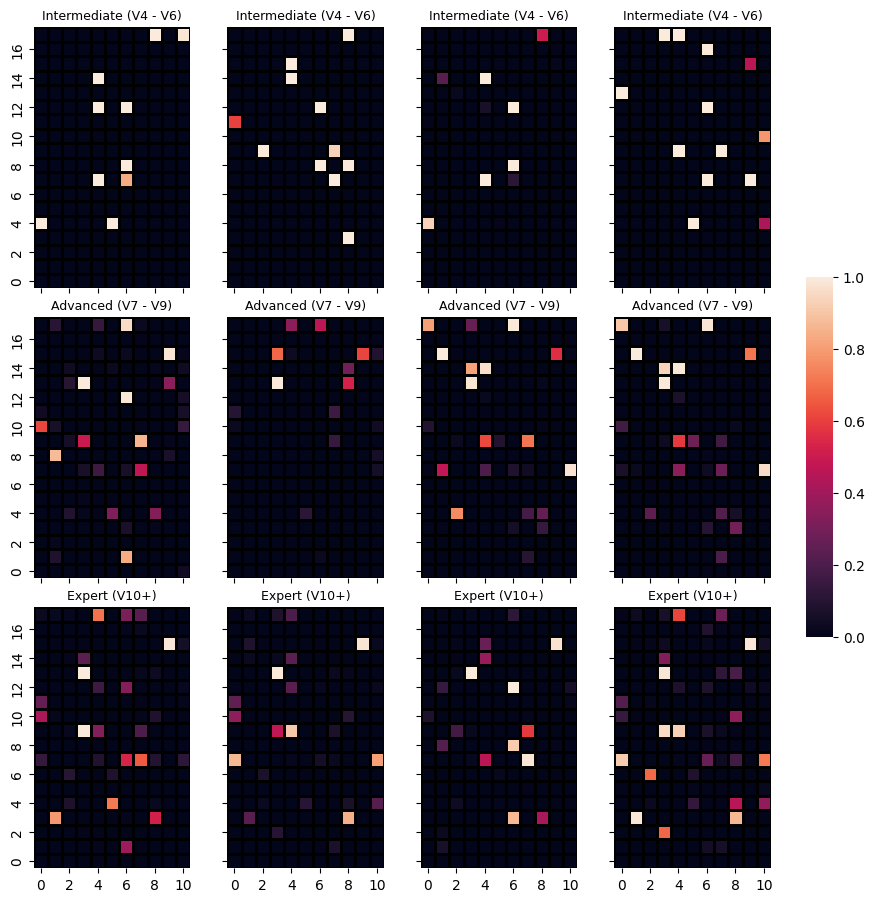

Epoch: 261 | Epoch Time: 0m 6s | Generator Loss: 0.093 | Discriminator Loss: -0.018


Epoch: 262 | Epoch Time: 0m 4s | Generator Loss: 0.102 | Discriminator Loss: -0.021


Epoch: 263 | Epoch Time: 0m 5s | Generator Loss: 0.107 | Discriminator Loss: -0.027


Epoch: 264 | Epoch Time: 0m 5s | Generator Loss: 0.111 | Discriminator Loss: -0.027


Epoch: 265 | Epoch Time: 0m 4s | Generator Loss: 0.115 | Discriminator Loss: -0.001


Epoch: 266 | Epoch Time: 0m 5s | Generator Loss: 0.101 | Discriminator Loss: -0.034


Epoch: 267 | Epoch Time: 0m 5s | Generator Loss: 0.101 | Discriminator Loss: -0.037


Epoch: 268 | Epoch Time: 0m 4s | Generator Loss: 0.114 | Discriminator Loss: -0.032


Epoch: 269 | Epoch Time: 0m 5s | Generator Loss: 0.120 | Discriminator Loss: -0.026


Epoch: 270 | Epoch Time: 0m 5s | Generator Loss: 0.118 | Discriminator Loss: -0.032
Checkpoint 27 - generated board probability maps (with same latent generation): 


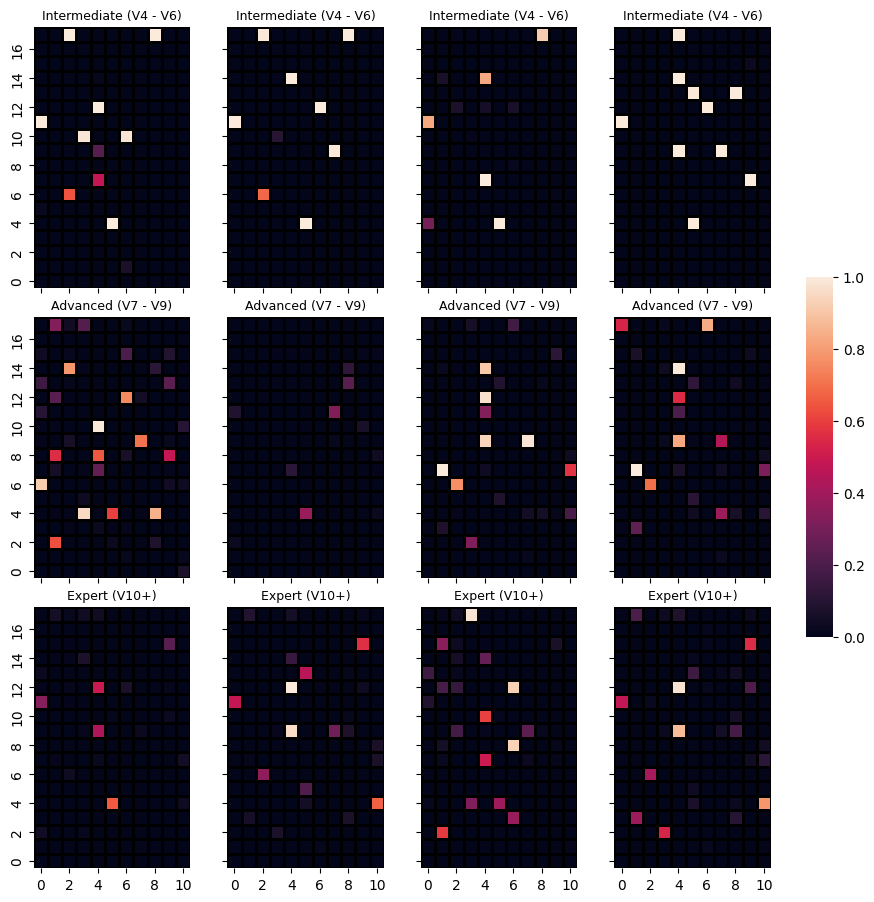

Epoch: 271 | Epoch Time: 0m 6s | Generator Loss: 0.101 | Discriminator Loss: -0.058


Epoch: 272 | Epoch Time: 0m 4s | Generator Loss: 0.145 | Discriminator Loss: -0.023


Epoch: 273 | Epoch Time: 0m 5s | Generator Loss: 0.109 | Discriminator Loss: -0.004


Epoch: 274 | Epoch Time: 0m 5s | Generator Loss: 0.103 | Discriminator Loss: -0.006


Epoch: 275 | Epoch Time: 0m 4s | Generator Loss: 0.100 | Discriminator Loss: -0.007


Epoch: 276 | Epoch Time: 0m 5s | Generator Loss: 0.096 | Discriminator Loss: -0.008


Epoch: 277 | Epoch Time: 0m 5s | Generator Loss: 0.100 | Discriminator Loss: -0.012


Epoch: 278 | Epoch Time: 0m 4s | Generator Loss: 0.096 | Discriminator Loss: -0.011


Epoch: 279 | Epoch Time: 0m 5s | Generator Loss: 0.094 | Discriminator Loss: -0.011


Epoch: 280 | Epoch Time: 0m 5s | Generator Loss: 0.095 | Discriminator Loss: -0.012
Checkpoint 28 - generated board probability maps (with same latent generation): 


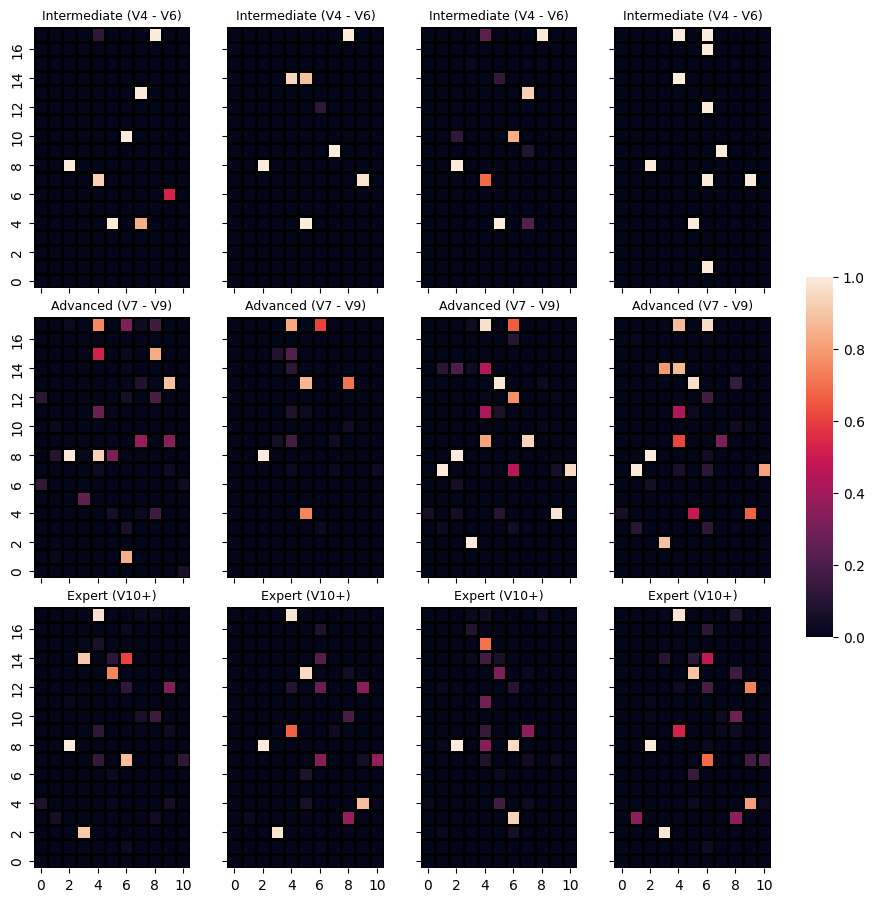

Epoch: 281 | Epoch Time: 0m 6s | Generator Loss: 0.093 | Discriminator Loss: -0.014


Epoch: 282 | Epoch Time: 0m 5s | Generator Loss: 0.093 | Discriminator Loss: -0.016


Epoch: 283 | Epoch Time: 0m 5s | Generator Loss: 0.094 | Discriminator Loss: -0.020


Epoch: 284 | Epoch Time: 0m 4s | Generator Loss: 0.092 | Discriminator Loss: -0.024


Epoch: 285 | Epoch Time: 0m 5s | Generator Loss: 0.010 | Discriminator Loss: -0.005


Epoch: 286 | Epoch Time: 0m 5s | Generator Loss: 0.026 | Discriminator Loss: -0.018


Epoch: 287 | Epoch Time: 0m 4s | Generator Loss: 0.031 | Discriminator Loss: -0.006


Epoch: 288 | Epoch Time: 0m 5s | Generator Loss: 0.058 | Discriminator Loss: -0.009


Epoch: 289 | Epoch Time: 0m 5s | Generator Loss: 0.056 | Discriminator Loss: -0.009


Epoch: 290 | Epoch Time: 0m 4s | Generator Loss: 0.061 | Discriminator Loss: -0.011
Checkpoint 29 - generated board probability maps (with same latent generation): 


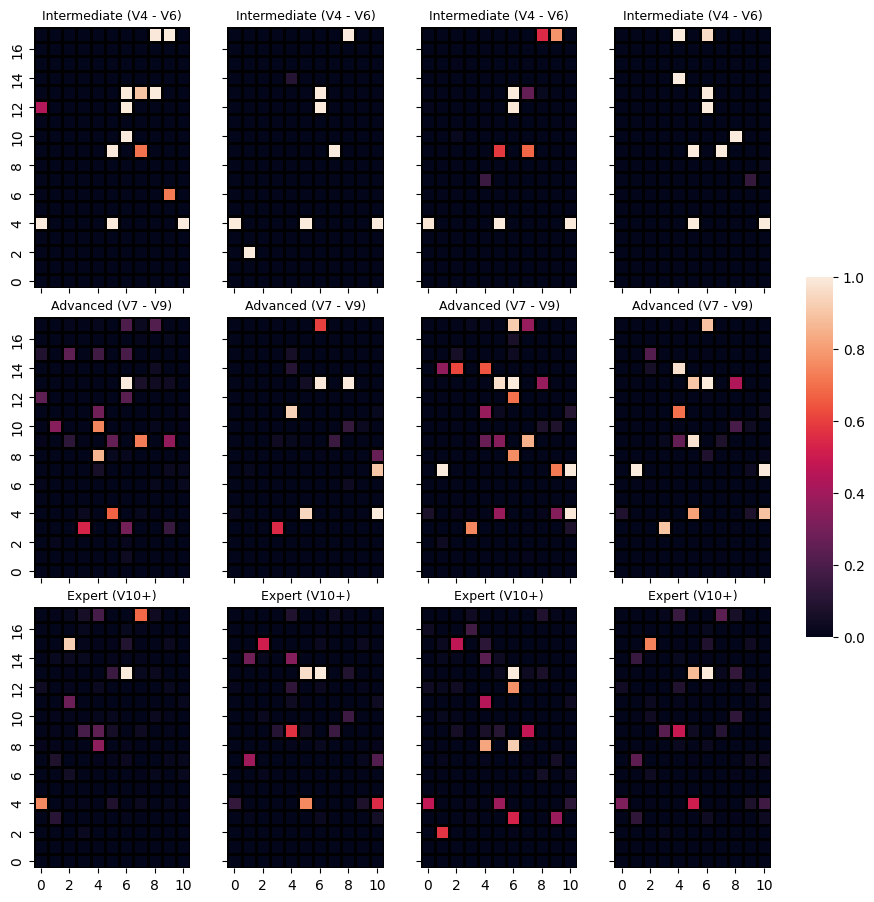

Epoch: 291 | Epoch Time: 0m 6s | Generator Loss: 0.064 | Discriminator Loss: -0.014


Epoch: 292 | Epoch Time: 0m 5s | Generator Loss: 0.065 | Discriminator Loss: -0.019


Epoch: 293 | Epoch Time: 0m 4s | Generator Loss: 0.062 | Discriminator Loss: -0.025


Epoch: 294 | Epoch Time: 0m 5s | Generator Loss: 0.054 | Discriminator Loss: -0.027


Epoch: 295 | Epoch Time: 0m 5s | Generator Loss: 0.044 | Discriminator Loss: 0.032


Epoch: 296 | Epoch Time: 0m 5s | Generator Loss: 0.063 | Discriminator Loss: -0.032


Epoch: 297 | Epoch Time: 0m 4s | Generator Loss: 0.057 | Discriminator Loss: -0.023


Epoch: 298 | Epoch Time: 0m 5s | Generator Loss: 0.065 | Discriminator Loss: -0.051


Epoch: 299 | Epoch Time: 0m 5s | Generator Loss: 0.068 | Discriminator Loss: -0.090


Epoch: 300 | Epoch Time: 0m 4s | Generator Loss: 0.073 | Discriminator Loss: -0.098
Checkpoint 30 - generated board probability maps (with same latent generation): 


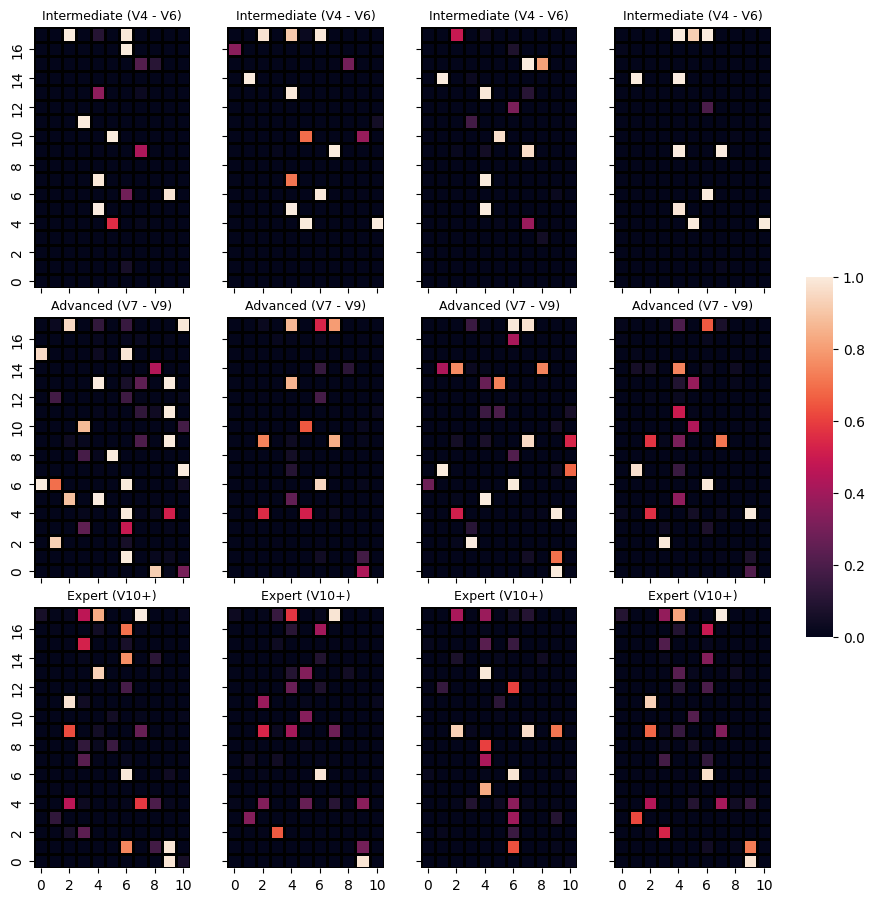

Epoch: 301 | Epoch Time: 0m 6s | Generator Loss: 0.105 | Discriminator Loss: 0.110


Epoch: 302 | Epoch Time: 0m 5s | Generator Loss: 0.103 | Discriminator Loss: -0.014


Epoch: 303 | Epoch Time: 0m 4s | Generator Loss: 0.095 | Discriminator Loss: -0.019


Epoch: 304 | Epoch Time: 0m 4s | Generator Loss: 0.089 | Discriminator Loss: -0.022


Epoch: 305 | Epoch Time: 0m 5s | Generator Loss: 0.083 | Discriminator Loss: -0.024


Epoch: 306 | Epoch Time: 0m 4s | Generator Loss: 0.083 | Discriminator Loss: -0.026


Epoch: 307 | Epoch Time: 0m 4s | Generator Loss: 0.087 | Discriminator Loss: -0.030


Epoch: 308 | Epoch Time: 0m 5s | Generator Loss: 0.100 | Discriminator Loss: -0.036


Epoch: 309 | Epoch Time: 0m 4s | Generator Loss: 0.117 | Discriminator Loss: -0.045


Epoch: 310 | Epoch Time: 0m 4s | Generator Loss: 0.144 | Discriminator Loss: -0.058
Checkpoint 31 - generated board probability maps (with same latent generation): 


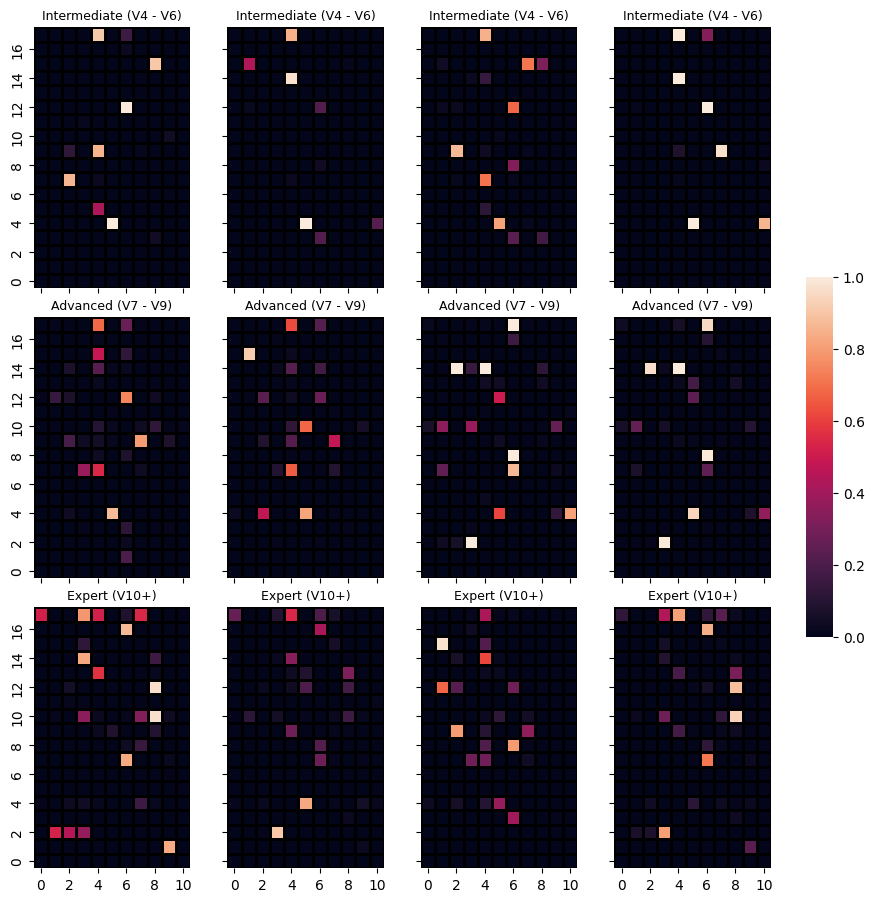

Epoch: 311 | Epoch Time: 0m 6s | Generator Loss: 0.170 | Discriminator Loss: -0.082


Epoch: 312 | Epoch Time: 0m 4s | Generator Loss: 0.026 | Discriminator Loss: 89.198


Epoch: 313 | Epoch Time: 0m 4s | Generator Loss: -0.020 | Discriminator Loss: 0.033


Epoch: 314 | Epoch Time: 0m 5s | Generator Loss: -0.017 | Discriminator Loss: 0.016


Epoch: 315 | Epoch Time: 0m 4s | Generator Loss: -0.018 | Discriminator Loss: 0.009


Epoch: 316 | Epoch Time: 0m 4s | Generator Loss: -0.016 | Discriminator Loss: 0.010


Epoch: 317 | Epoch Time: 0m 5s | Generator Loss: 0.002 | Discriminator Loss: -0.012


Epoch: 318 | Epoch Time: 0m 5s | Generator Loss: -0.019 | Discriminator Loss: 0.001


Epoch: 319 | Epoch Time: 0m 4s | Generator Loss: 0.031 | Discriminator Loss: -0.015


Epoch: 320 | Epoch Time: 0m 5s | Generator Loss: -0.016 | Discriminator Loss: 0.004
Checkpoint 32 - generated board probability maps (with same latent generation): 


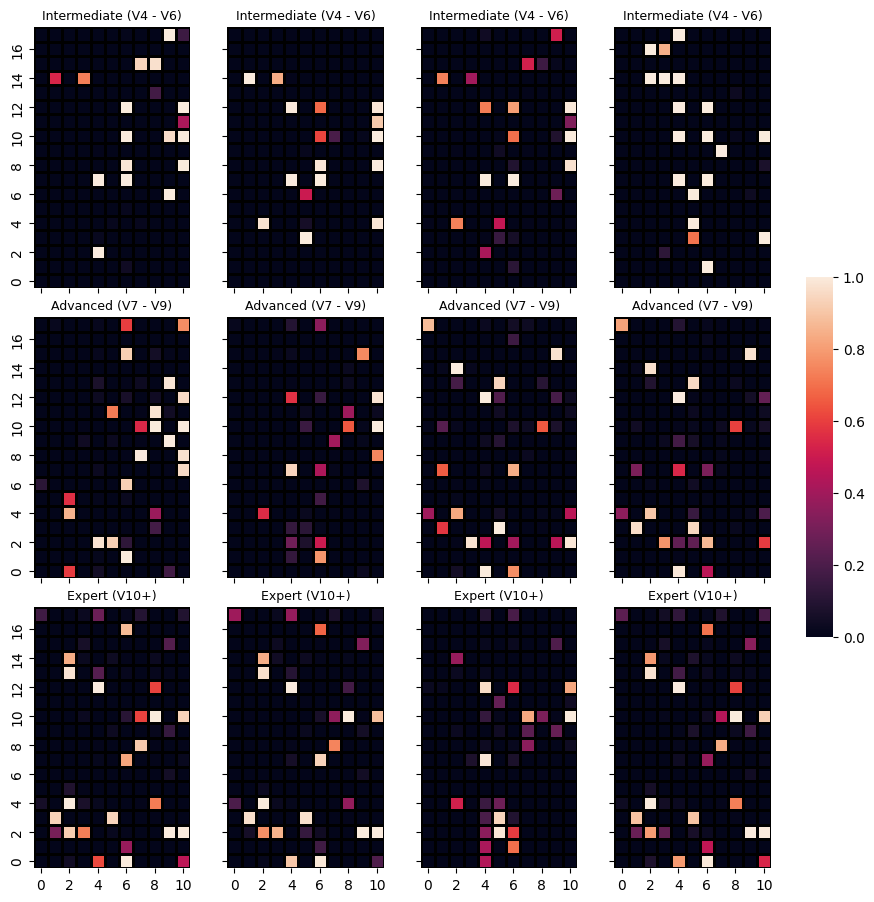

Epoch: 321 | Epoch Time: 0m 6s | Generator Loss: -0.016 | Discriminator Loss: 0.004


Epoch: 322 | Epoch Time: 0m 5s | Generator Loss: -0.019 | Discriminator Loss: -0.001


Epoch: 323 | Epoch Time: 0m 5s | Generator Loss: -0.020 | Discriminator Loss: -0.007


Epoch: 324 | Epoch Time: 0m 4s | Generator Loss: -0.010 | Discriminator Loss: 0.018


Epoch: 325 | Epoch Time: 0m 4s | Generator Loss: -0.003 | Discriminator Loss: 0.007


Epoch: 326 | Epoch Time: 0m 4s | Generator Loss: -0.005 | Discriminator Loss: 0.006


Epoch: 327 | Epoch Time: 0m 5s | Generator Loss: -0.013 | Discriminator Loss: -0.003


Epoch: 328 | Epoch Time: 0m 4s | Generator Loss: -0.004 | Discriminator Loss: 0.024


Epoch: 329 | Epoch Time: 0m 4s | Generator Loss: 0.001 | Discriminator Loss: 0.004


Epoch: 330 | Epoch Time: 0m 5s | Generator Loss: -0.002 | Discriminator Loss: -0.011
Checkpoint 33 - generated board probability maps (with same latent generation): 


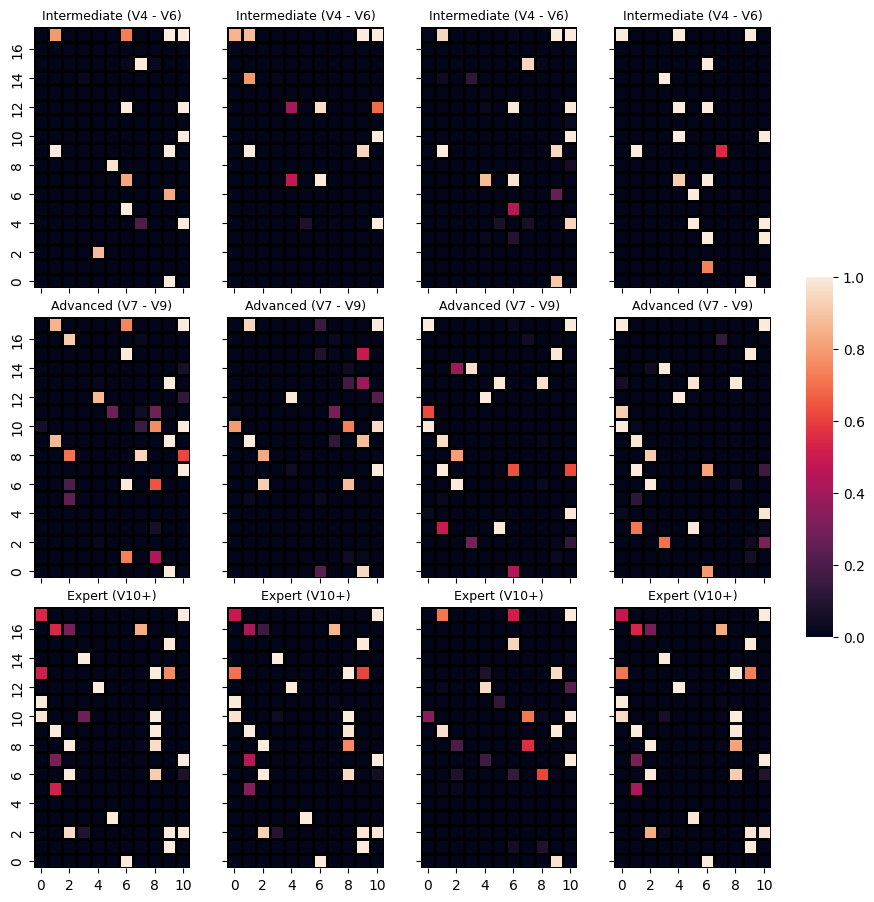

Epoch: 331 | Epoch Time: 0m 6s | Generator Loss: 0.007 | Discriminator Loss: -0.058


Epoch: 332 | Epoch Time: 0m 5s | Generator Loss: 0.005 | Discriminator Loss: -0.118


Epoch: 333 | Epoch Time: 0m 5s | Generator Loss: 0.014 | Discriminator Loss: -0.181


Epoch: 334 | Epoch Time: 0m 5s | Generator Loss: 0.026 | Discriminator Loss: 0.355


Epoch: 335 | Epoch Time: 0m 4s | Generator Loss: 0.018 | Discriminator Loss: -0.003


Epoch: 336 | Epoch Time: 0m 5s | Generator Loss: 0.013 | Discriminator Loss: -0.006


Epoch: 337 | Epoch Time: 0m 5s | Generator Loss: 0.012 | Discriminator Loss: -0.004


Epoch: 338 | Epoch Time: 0m 4s | Generator Loss: 0.015 | Discriminator Loss: -0.020


Epoch: 339 | Epoch Time: 0m 5s | Generator Loss: 0.023 | Discriminator Loss: -0.029


Epoch: 340 | Epoch Time: 0m 5s | Generator Loss: 0.024 | Discriminator Loss: -0.021
Checkpoint 34 - generated board probability maps (with same latent generation): 


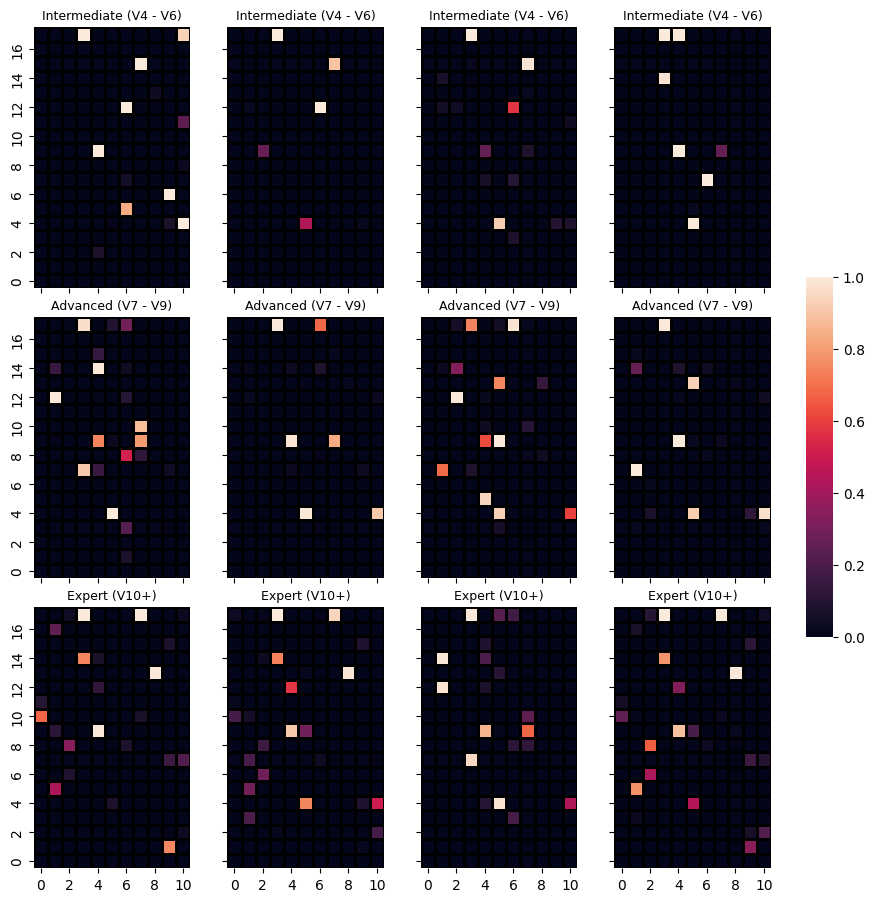

Epoch: 341 | Epoch Time: 0m 6s | Generator Loss: 0.026 | Discriminator Loss: -0.025


Epoch: 342 | Epoch Time: 0m 5s | Generator Loss: 0.026 | Discriminator Loss: -0.023


Epoch: 343 | Epoch Time: 0m 5s | Generator Loss: 0.027 | Discriminator Loss: -0.012


Epoch: 344 | Epoch Time: 0m 4s | Generator Loss: 0.036 | Discriminator Loss: -0.022


Epoch: 345 | Epoch Time: 0m 5s | Generator Loss: 0.037 | Discriminator Loss: -0.029


Epoch: 346 | Epoch Time: 0m 5s | Generator Loss: 0.035 | Discriminator Loss: -0.024


Epoch: 347 | Epoch Time: 0m 4s | Generator Loss: 0.040 | Discriminator Loss: -0.024


Epoch: 348 | Epoch Time: 0m 5s | Generator Loss: 0.044 | Discriminator Loss: -0.026


Epoch: 349 | Epoch Time: 0m 5s | Generator Loss: 0.048 | Discriminator Loss: -0.024


Epoch: 350 | Epoch Time: 0m 5s | Generator Loss: 0.025 | Discriminator Loss: -0.026
Checkpoint 35 - generated board probability maps (with same latent generation): 


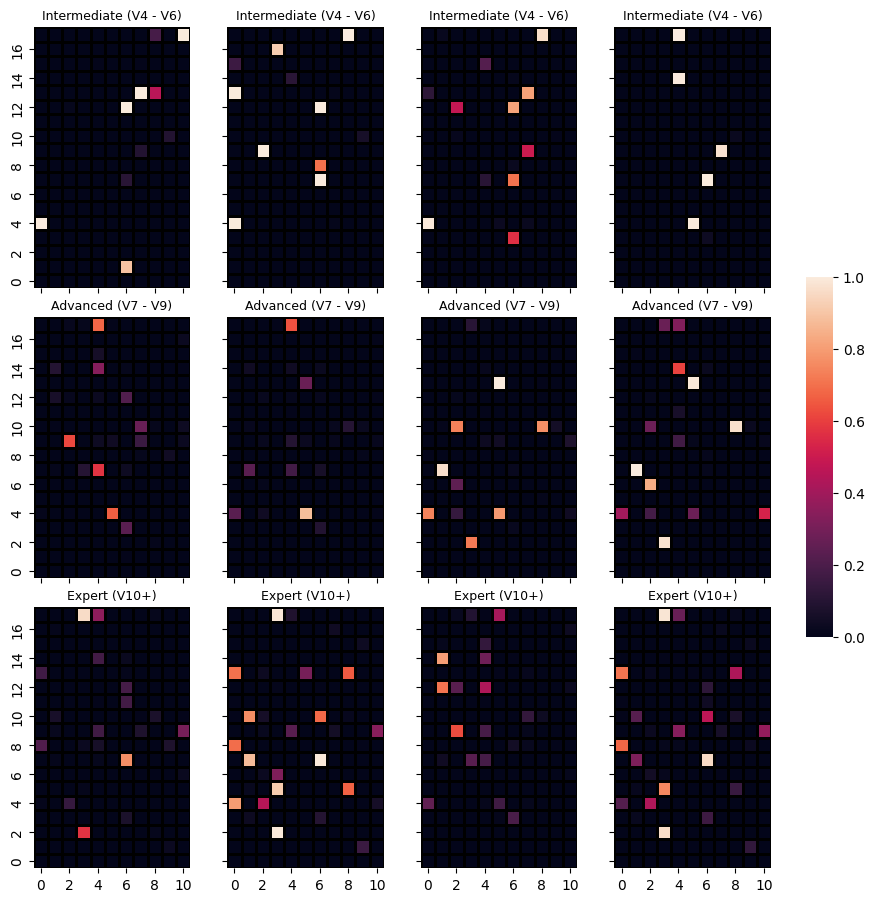

Epoch: 351 | Epoch Time: 0m 6s | Generator Loss: 0.025 | Discriminator Loss: -0.039


Epoch: 352 | Epoch Time: 0m 5s | Generator Loss: 0.031 | Discriminator Loss: -0.062


Epoch: 353 | Epoch Time: 0m 5s | Generator Loss: 0.032 | Discriminator Loss: -0.036


Epoch: 354 | Epoch Time: 0m 4s | Generator Loss: 0.035 | Discriminator Loss: -0.036


Epoch: 355 | Epoch Time: 0m 5s | Generator Loss: 0.029 | Discriminator Loss: 0.010


Epoch: 356 | Epoch Time: 0m 5s | Generator Loss: 0.027 | Discriminator Loss: -0.016


Epoch: 357 | Epoch Time: 0m 4s | Generator Loss: 0.029 | Discriminator Loss: -0.021


Epoch: 358 | Epoch Time: 0m 5s | Generator Loss: 0.014 | Discriminator Loss: -0.008


Epoch: 359 | Epoch Time: 0m 5s | Generator Loss: 0.013 | Discriminator Loss: -0.008


Epoch: 360 | Epoch Time: 0m 5s | Generator Loss: 0.014 | Discriminator Loss: -0.013
Checkpoint 36 - generated board probability maps (with same latent generation): 


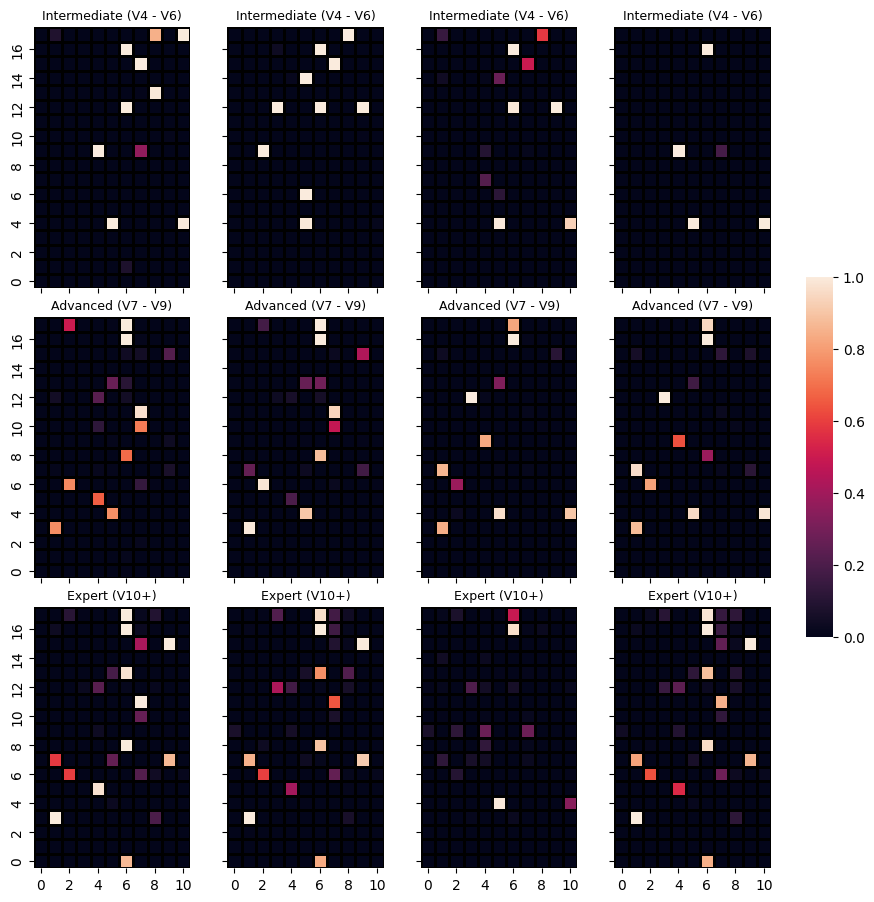

Epoch: 361 | Epoch Time: 0m 6s | Generator Loss: 0.014 | Discriminator Loss: -0.022


Epoch: 362 | Epoch Time: 0m 5s | Generator Loss: 0.005 | Discriminator Loss: -0.021


Epoch: 363 | Epoch Time: 0m 4s | Generator Loss: 0.005 | Discriminator Loss: -0.020


Epoch: 364 | Epoch Time: 0m 5s | Generator Loss: 0.005 | Discriminator Loss: 0.157


Epoch: 365 | Epoch Time: 0m 5s | Generator Loss: -0.009 | Discriminator Loss: -0.005


Epoch: 366 | Epoch Time: 0m 4s | Generator Loss: -0.015 | Discriminator Loss: -0.009


Epoch: 367 | Epoch Time: 0m 4s | Generator Loss: -0.014 | Discriminator Loss: -0.038


Epoch: 368 | Epoch Time: 0m 4s | Generator Loss: 0.014 | Discriminator Loss: 79.190


Epoch: 369 | Epoch Time: 0m 4s | Generator Loss: -0.179 | Discriminator Loss: 0.570


Epoch: 370 | Epoch Time: 0m 5s | Generator Loss: -0.209 | Discriminator Loss: 0.257
Checkpoint 37 - generated board probability maps (with same latent generation): 


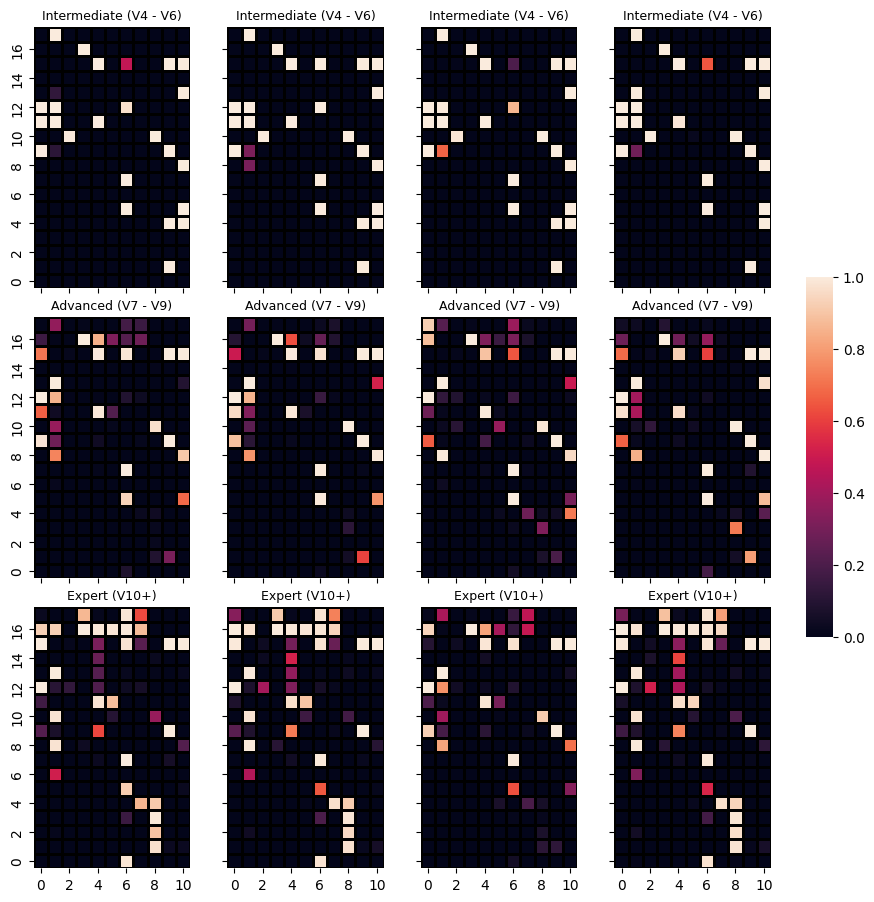

Epoch: 371 | Epoch Time: 0m 6s | Generator Loss: -0.031 | Discriminator Loss: 0.031


Epoch: 372 | Epoch Time: 0m 4s | Generator Loss: 0.060 | Discriminator Loss: -0.043


Epoch: 373 | Epoch Time: 0m 4s | Generator Loss: 0.019 | Discriminator Loss: -0.039


Epoch: 374 | Epoch Time: 0m 5s | Generator Loss: 0.002 | Discriminator Loss: -0.025


Epoch: 375 | Epoch Time: 0m 4s | Generator Loss: 0.018 | Discriminator Loss: 28.170


Epoch: 376 | Epoch Time: 0m 4s | Generator Loss: -0.002 | Discriminator Loss: 0.047


Epoch: 377 | Epoch Time: 0m 5s | Generator Loss: -0.007 | Discriminator Loss: 0.029


Epoch: 378 | Epoch Time: 0m 5s | Generator Loss: 0.001 | Discriminator Loss: 0.021


Epoch: 379 | Epoch Time: 0m 4s | Generator Loss: -0.005 | Discriminator Loss: 0.007


Epoch: 380 | Epoch Time: 0m 5s | Generator Loss: -0.007 | Discriminator Loss: 0.005
Checkpoint 38 - generated board probability maps (with same latent generation): 


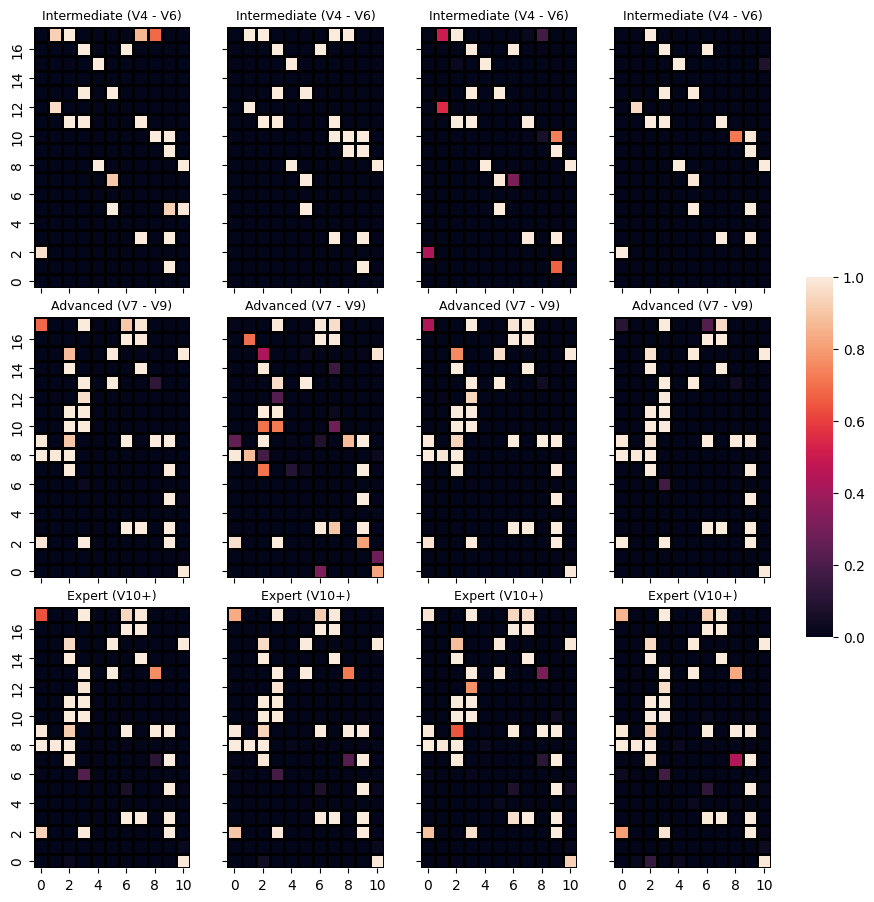

Epoch: 381 | Epoch Time: 0m 6s | Generator Loss: 0.032 | Discriminator Loss: -0.032


Epoch: 382 | Epoch Time: 0m 4s | Generator Loss: -0.002 | Discriminator Loss: -0.010


Epoch: 383 | Epoch Time: 0m 5s | Generator Loss: -0.004 | Discriminator Loss: -0.015


Epoch: 384 | Epoch Time: 0m 5s | Generator Loss: -0.002 | Discriminator Loss: -0.032


Epoch: 385 | Epoch Time: 0m 4s | Generator Loss: 0.002 | Discriminator Loss: -0.196


Epoch: 386 | Epoch Time: 0m 4s | Generator Loss: 0.003 | Discriminator Loss: -0.025


Epoch: 387 | Epoch Time: 0m 5s | Generator Loss: -0.002 | Discriminator Loss: -0.037


Epoch: 388 | Epoch Time: 0m 5s | Generator Loss: -0.008 | Discriminator Loss: -0.032


Epoch: 389 | Epoch Time: 0m 5s | Generator Loss: -0.007 | Discriminator Loss: -0.001


Epoch: 390 | Epoch Time: 0m 5s | Generator Loss: -0.004 | Discriminator Loss: 1.861
Checkpoint 39 - generated board probability maps (with same latent generation): 


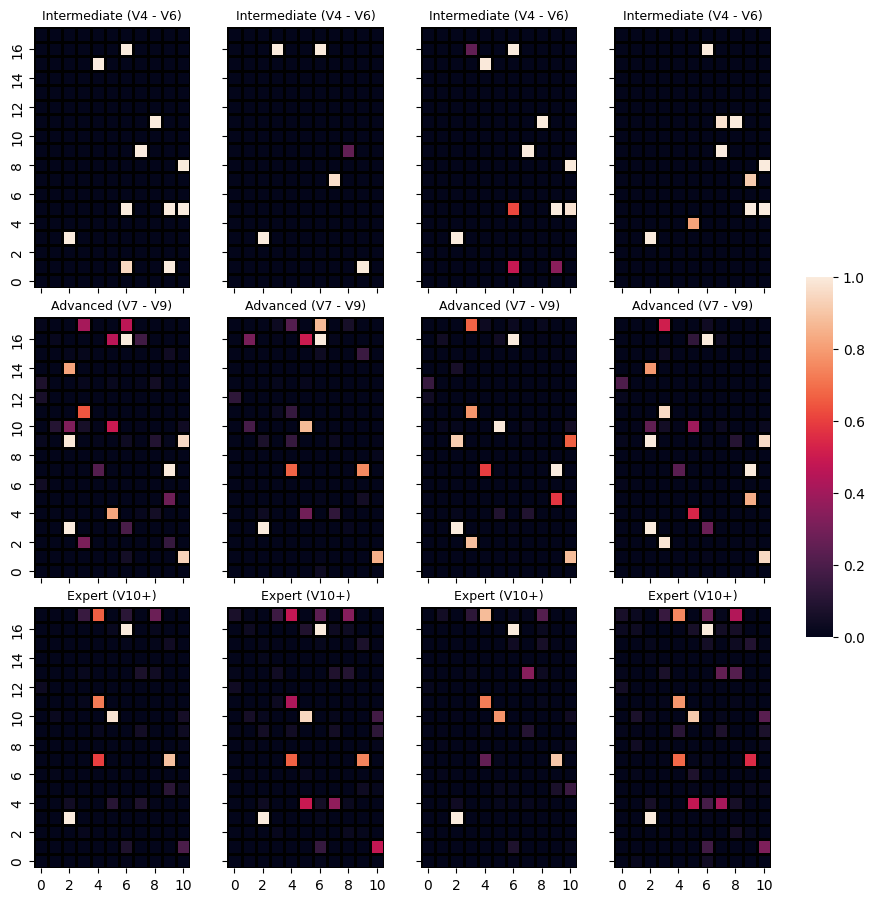

Epoch: 391 | Epoch Time: 0m 6s | Generator Loss: -0.005 | Discriminator Loss: 0.002


Epoch: 392 | Epoch Time: 0m 4s | Generator Loss: -0.003 | Discriminator Loss: -0.002


Epoch: 393 | Epoch Time: 0m 5s | Generator Loss: 0.000 | Discriminator Loss: -0.005


Epoch: 394 | Epoch Time: 0m 4s | Generator Loss: 0.004 | Discriminator Loss: -0.022


Epoch: 395 | Epoch Time: 0m 4s | Generator Loss: 0.006 | Discriminator Loss: -0.027


Epoch: 396 | Epoch Time: 0m 5s | Generator Loss: -0.002 | Discriminator Loss: 0.024


Epoch: 397 | Epoch Time: 0m 5s | Generator Loss: -0.008 | Discriminator Loss: 0.001


Epoch: 398 | Epoch Time: 0m 5s | Generator Loss: -0.008 | Discriminator Loss: -0.001


Epoch: 399 | Epoch Time: 0m 5s | Generator Loss: -0.003 | Discriminator Loss: -0.014


Epoch: 400 | Epoch Time: 0m 5s | Generator Loss: -0.002 | Discriminator Loss: -0.037
Final generated board probability maps (with same latent generation): 


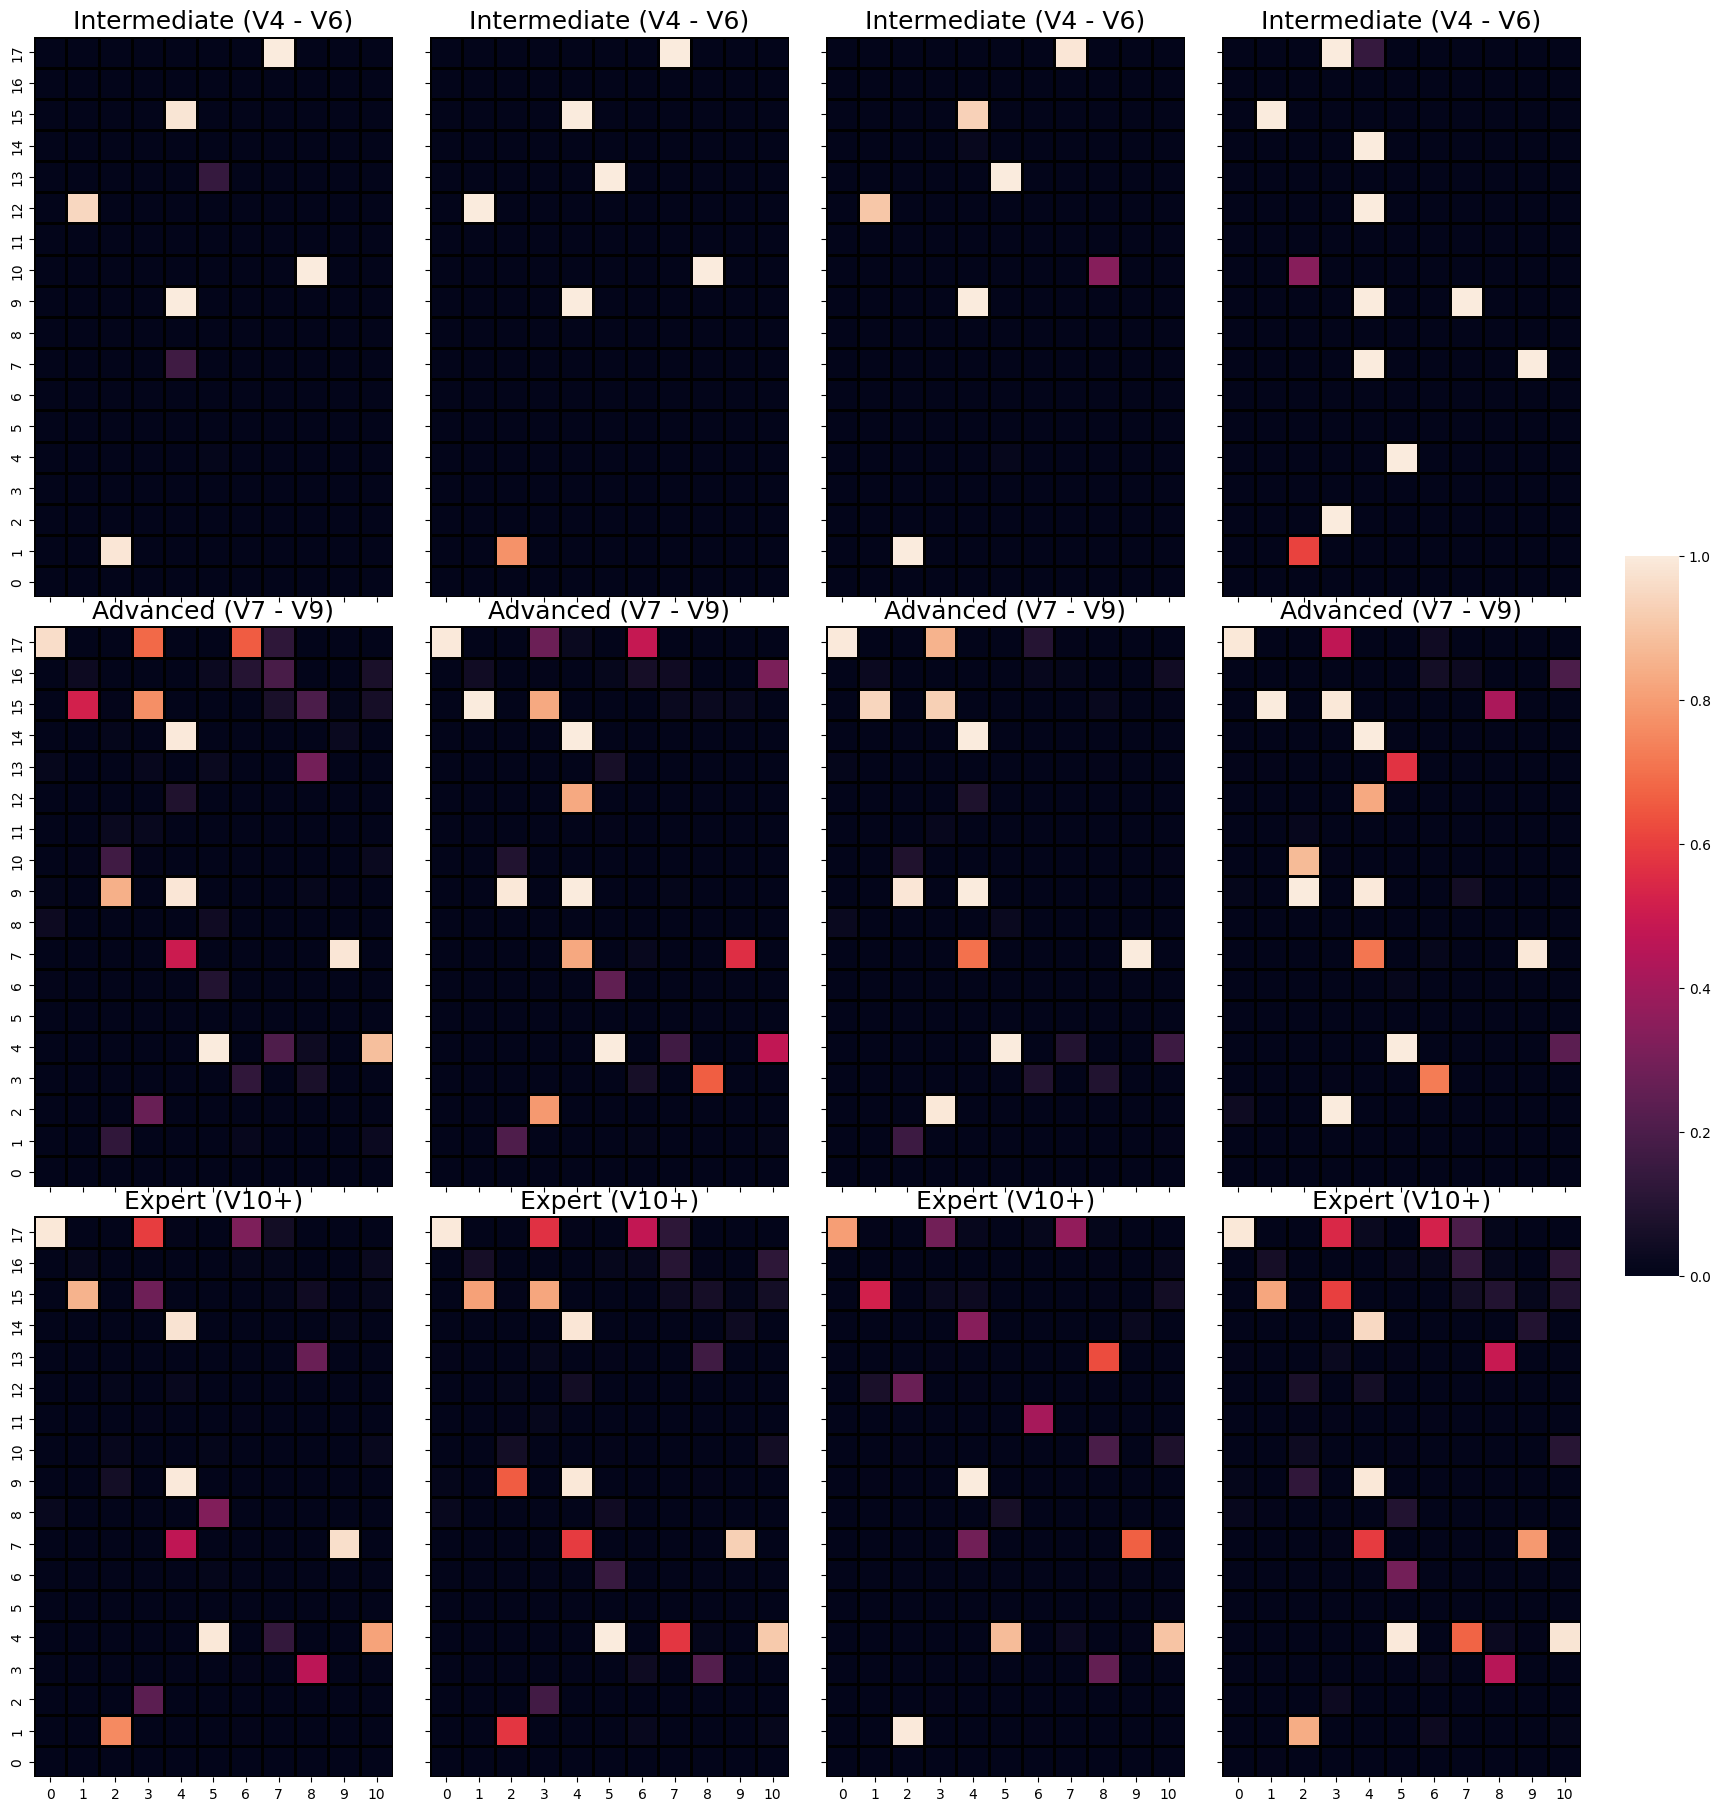

In [28]:
import time
from tqdm import tqdm
from torch.optim import Adam

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

EPOCHS = 400

BATCH_SIZE = 64 # we want large batch sizes for training to smooth the gradient for our discrete data

train_iterator = data.DataLoader(train_dataset,
                                 sampler=sampler,
                                 batch_size=BATCH_SIZE)


generator = Generator(output_dim=INPUT_DIM, latent_dim=LATENT_DIM_G, class_dim=CLASS_DIM).to(device)
discriminator = Discriminator(input_dim=INPUT_DIM, output_dim=1, class_dim=CLASS_DIM).to(device)

g_opt = Adam(generator.parameters(), lr=1e-3)
d_opt = Adam(discriminator.parameters(), lr=1e-3, weight_decay=1e-5)

def train(generator, discriminator, iterator, g_opt, d_opt, device, eps = 5e-2, diversity_lambda = 5e-2, l1_lambda = 1e-4, num_disc_steps = 2):

    epoch_g_loss = epoch_d_loss = 0

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.view(x.size(0), -1)
        x = x.to(device)
        y = y.to(device)

        batch_size = x.size(0)

        # smooth our sample to convert it to a probabalistic map instead of a discrete board
        # instead of generating a full problem we generate some probability of a hold showing up in a spot
        probs = torch.zeros_like(x).uniform_(0, eps)
        smoothed_x = x * (1 - probs) + probs / 2

        # now set the items we know don't ever have holds to zero (hold showing up in these spots are of probability zero)
        # since our x is flat we use the 1D access formula for 2D arrays
        smoothed_x[:, zero_indices[:, 0] * 11 + zero_indices[:, 1]] = 0

        # start by training the discriminator some number of times
        for i in range(num_disc_steps):
            d_opt.zero_grad()
            
            # Sample noise and labels as generator input
            z = torch.normal(0, 1, size=(batch_size, LATENT_DIM_G)).to(device)
            gen_labels = generate_class_labels(batch_size).to(device)
        
            # generate our fake examples
            gen_in = torch.cat([z.detach(), gen_labels.detach()], 1) # concatenate the class with the input
            gen_boards = generator(gen_in)
    
            # Loss for real images
            disc_in_real = torch.cat([smoothed_x, y], 1) # concatenate the class with the input
            real_guess = discriminator(disc_in_real)
    
            # Loss for fake images
            disc_in_fake = torch.cat([gen_boards.detach(), gen_labels.detach()], 1) # concatenate the class with the input
            fake_guess = discriminator(disc_in_fake)
    
            # gradient penalty
            g_pen = gradient_penalty(generator, discriminator, disc_in_real, disc_in_fake, device)
    
            # Total discriminator loss
            d_loss = -torch.mean(real_guess) + torch.mean(fake_guess) + g_pen
    
            d_loss.backward()
            d_opt.step()

        # then train the generator
        g_opt.zero_grad()
    
        # Sample noise and labels as generator input
        z = torch.normal(0, 1, size=(batch_size, LATENT_DIM_G)).to(device)
        gen_labels = generate_class_labels(batch_size).to(device)
    
        # generate our fake examples
        gen_in = torch.cat([z, gen_labels], 1) # concatenate the class with the input
        gen_boards = generator(gen_in)
    
        # test against the critic
        gen_in_fake = torch.cat([gen_boards, gen_labels], 1) # concatenate the class with the input
        gen_guess = discriminator(gen_in_fake)
        g_score = -torch.mean(gen_guess)

        # Diversity related regularization
        
        # generate another batch of examples with the same labels
        z2 = torch.normal(0, 1, size=(batch_size, LATENT_DIM_G)).to(device)
        gen_in2 = torch.cat([z2, gen_labels], 1) # concatenate the class with the input
        gen_boards2 = generator(gen_in2)

        # use pairwise distance to get distance between sample pairs in a batch
        # L1 distance could perform better in high dimensional contexts than L2 and higher norm distances
        # there was a neat paper on it that I happened to run across: https://bib.dbvis.de/uploadedFiles/155.pdf
        dist_calc = torch.nn.PairwiseDistance(p=1) 
        
        # Compute distance between samples in latent space
        latent_distances = dist_calc(z, z2) 
        
        # Compute distance between generator samples
        gen_distances = dist_calc(gen_boards, gen_boards2)
        
        # Regularization term as the ratio between the distances in the latent space and distances in the output space
        div_reg = diversity_lambda * (torch.sum(latent_distances) / (torch.sum(gen_distances) + 1e-12))

        # L1 Regularization on the output to encourage sparsity
        l1_reg = l1_lambda * torch.sum(gen_boards) / BATCH_SIZE

        # full generator loss as a combination of these terms
        g_loss = g_score + div_reg + l1_reg

        g_loss.backward()
        g_opt.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    return epoch_g_loss / (len(iterator) * BATCH_SIZE), epoch_d_loss / (len(iterator) * BATCH_SIZE)

total_params_g = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print(f"Generator - Number of trainable parameters: {total_params_g:,}")
total_params_d = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"Discriminator - Number of trainable parameters: {total_params_d:,}")


# Sample noise and labels as generator input
z = torch.normal(0, 1, size=(12, LATENT_DIM_G)).to(device)
gen_labels = torch.tensor([[0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 1], [1, 1], [1, 1], [1, 1]]).to(device)

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    if epoch % 10 == 0:
        with torch.no_grad():
            # generate our fake examples to view
            print(f"Checkpoint {epoch / 10:.0f} - generated board probability maps (with same latent generation): ")
            gen_in = torch.cat([z, gen_labels], 1) # concatenate the class with the input
            gen_boards = generator(gen_in).reshape(12, 18, 11).detach()
            plot_examples(gen_boards, gen_labels)
    generator_loss, discriminator_loss = train(generator, discriminator, train_iterator, g_opt, d_opt, device)
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s', end=' | ')
    print(f'Generator Loss: {generator_loss:.3f} | Discriminator Loss: {discriminator_loss:.3f}')
    
print(f"Final generated board probability maps (with same latent generation): ")
gen_in = torch.cat([z, gen_labels], 1) # concatenate the class with the input
gen_boards = generator(gen_in).reshape(12, 18, 11).detach()
plot_examples(gen_boards, gen_labels, figure_size=(18, 18))

In [57]:
# this uses the problem map to generate a board problem
def build_problem_from_map(generated_board_map, num_middle_holds, num_start_holds, num_end_holds):
    generated_board_map = generated_board_map.view(18, 11, 1)
    board = np.zeros((18, 11, 2))
    # first get start hold(s)
    v, i = torch.topk(generated_board_map[:6, :].flatten(), num_start_holds)
    idx_list = np.array(np.unravel_index(i.cpu().numpy(), (6, 11))).T
    for[x, y] in idx_list:
        board[x, y, 1] = 1
    
    # then get middle holds
    v, i = torch.topk(generated_board_map[6:17, :].flatten(), num_middle_holds)
    idx_list = np.array(np.unravel_index(i.cpu().numpy(), (11, 11))).T
    for[x, y] in idx_list:
        board[x + 6, y, 0] = 1
    
    # then end hold(s)
    v, i = torch.topk(generated_board_map[17:, :].flatten(), num_end_holds)
    idx_list = np.array(np.unravel_index(i.cpu().numpy(), (1, 11))).T
    for[x, y] in idx_list:
        board[x + 17, y, 1] = 1
    return board

In [34]:
def print_board_bar():
    for i in range(26):
        print("-", end="")
    print()

def print_board(board, grade):
    print(" "*3, end="| ")
    for i in range(11):
        print(f"{chr(i + 65)}", end=" ")
    print()
    print_board_bar()
    for i in range(18):
        print(f"{18 - i:2} |", end=" ")
        for j in range(11):
            num_printed = False
            for c in range(2):
                if board[17 - i, j, c] > 0:
                    char = "M"
                    if c > 0:
                        char = "S" if i >= 12 else "E"
                    print(char, end=" ")  
                    num_printed = True
            if not num_printed:
                print("-", end=" ")
        print()
    print_board_bar()
    print(f"Grade: {grade}")

In [63]:
with torch.no_grad():
    noise = torch.normal(0, 1, size=(1, LATENT_DIM_G)).to(device)
    label = torch.stack([tensor_dict[1]]).to(device)
    gen_in = torch.cat([noise, label], 1)
    board_map = generator(gen_in).reshape(18, 11)
    # now force the board map to be valid with our zero indicies from before
    board_map[zero_indices[:, 0], zero_indices[:, 1]] = 0

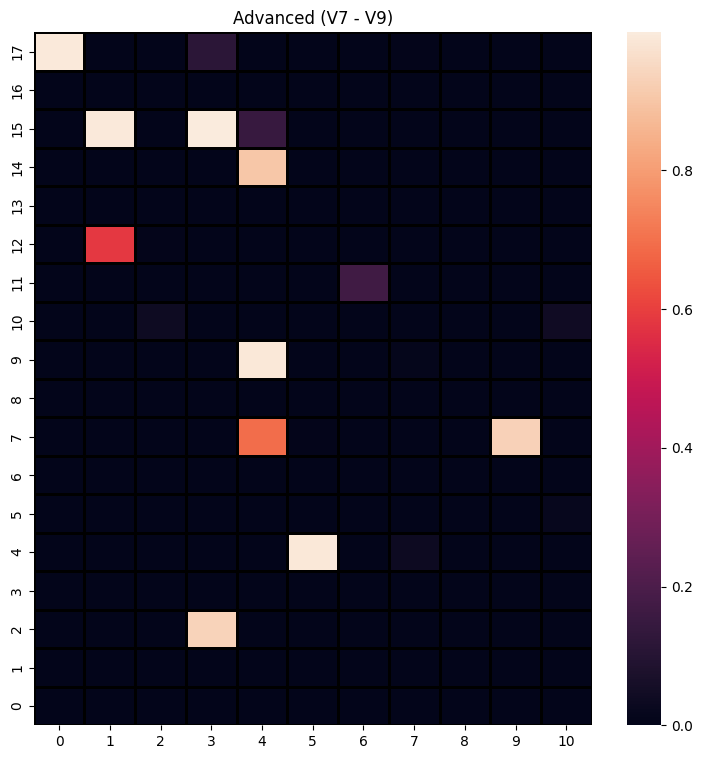

In [64]:
plot_example(board_map, label)

In [65]:
board = build_problem_from_map(board_map, 3, 1, 1)
print_board(board, class_to_title[int(torch.sum(label.cpu()).item())])

   | A B C D E F G H I J K 
--------------------------
18 | E - - - - - - - - - - 
17 | - - - - - - - - - - - 
16 | - M - M - - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - - - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - - - - 
10 | - - - - M - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Grade: Advanced (V7 - V9)
